In [35]:
# Import all the necessary modules
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas_datareader as pdr
import math
import datetime
import itertools
import yfinance as yf
import seaborn as sn
from IPython.display import display, HTML
from trend_following_signal import (apply_jupyter_fullscreen_css, load_financial_data, get_returns_volatility, calculate_slope, trend_signal, slope_signal, 
                             create_trend_strategy, get_close_prices, calculate_donchian_channels)
from strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
import coinbase_utils as cn
import strategy_performance as perf
import position_sizing as size
import trend_following_signal as tf
%matplotlib inline

In [37]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)
importlib.reload(size)

<module 'position_sizing' from '/Users/adheerchauhan/Documents/git/trend_following/position_sizing.py'>

In [39]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

In [4]:
client = cn.get_coinbase_rest_api_client(cn.key_location)

In [8]:
def get_coinbase_daily_historical_price_data_hour(client, ticker, start_timestamp, end_timestamp, retries=3, delay=5, granularity='ONE_HOUR'):
    # granularity = 'ONE_DAY'  # Daily granularity
    attempts = 0

    while attempts < retries:
        try:
            # Attempt to fetch the candles
            candle_list = client.get_candles(
                product_id=ticker,
                start=start_timestamp,
                end=end_timestamp,
                granularity=granularity
            ).candles

            # Process candle data
            candle_data = []
            for candles in candle_list:
                candle_info = {
                    'date': candles['start'],
                    'low': float(candles['low']),
                    'high': float(candles['high']),
                    'open': float(candles['open']),
                    'close': float(candles['close']),
                    'volume': float(candles['volume'])
                }
                candle_data.append(candle_info)

            # Convert to DataFrame
            df_candles = pd.DataFrame(candle_data).sort_values('date')
            df_candles['date'] = pd.to_datetime(df_candles['date'], unit='s').dt.date
            df_candles = df_candles.set_index('date')
            # df_candles['ticker'] = ticker

            return df_candles, candle_list

        except requests.exceptions.ConnectionError as e:
            print(f"Connection error: {e}. Retrying in {delay} seconds...")
            attempts += 1
            time.sleep(delay)

    # If all retries fail, raise the error
    raise Exception("Max retries exceeded. Could not connect to Coinbase API.")

In [10]:
import requests
import time
import datetime
import pandas as pd

def get_coinbase_price_at_timestamp(client, ticker, start_date, end_date, timestamp='08:00:00', retries=3, delay=5):
    """
    Fetches the price of a cryptocurrency at a specified timestamp for using the Coinbase REST API.

    Parameters:
    - client: The Coinbase API client
    - ticker: The crypto trading pair (e.g., 'BTC-USD')
    - retries: Number of retry attempts in case of failure
    - delay: Delay between retries in seconds

    Returns:
    - A Pandas DataFrame with date and 8 AM price
    """

    date_list = pd.date_range(start=start_date, end=end_date, freq="D")
    price_data = []

    for date in date_list:
        start_timestamp = int(datetime.datetime.strptime(f'{date.date()} {timestamp}','%Y-%m-%d %H:%M:%S').timestamp())
        end_timestamp = int(datetime.datetime.strptime(f'{date.date()} {timestamp}','%Y-%m-%d %H:%M:%S').timestamp())

        attempts = 0
        while attempts < retries:
            try:
                # Fetch 8 AM hourly candle
                candle_list = client.get_candles(
                    product_id=ticker,
                    start=start_timestamp,
                    end=end_timestamp,
                    granularity='ONE_MINUTE'  # Minute candles
                ).candles

                if candle_list:
                    # Extract price at timestamp
                    candles = candle_list[0]  # [timestamp, low, high, open, close, volume]
                    price_data.append({
                        'date': datetime.datetime.utcfromtimestamp(int(candles['start'])).date(),
                        '8am_open_price': float(candles['open']),
                        '8am_close_price': float(candles['close'])
                    })

                break  # Exit retry loop if successful

            except requests.exceptions.ConnectionError as e:
                print(f"Connection error: {e}. Retrying in {delay} seconds...")
                attempts += 1
                time.sleep(delay)

        if attempts == retries:
            print(f"Failed to fetch data for {date.strftime('%Y-%m-%d')} after {retries} retries.")

    # Convert to DataFrame
    df_prices = pd.DataFrame(price_data)
    df_prices.set_index('date', inplace=True)

    return df_prices

In [12]:
def save_historical_crypto_prices_at_timestamp_from_coinbase(ticker_list, user_start_date=False, start_date=None, end_date=None, window_days=30, timestamp='08:00:00',
                                                             save_to_file=False):

    client = cn.get_coinbase_rest_api_client(cn.key_location)
    
    price_dict = {}
    for ticker in ticker_list:
        if user_start_date:
            start_date = pd.Timestamp(start_date).date()
        else:
            start_date = cn.coinbase_start_date_by_ticker_dict.get(ticker)
            start_date = pd.Timestamp(start_date).date()
            if not start_date:
                print(f"Start date for {ticker} is not included in the dictionary!")
                return None
    
        if pd.Timestamp(end_date).date() > datetime.datetime.now().date():
            end_date = datetime.datetime.now().date()
        current_start_date = start_date
        current_end_date = current_start_date + datetime.timedelta(days=window_days)
        cols = [f'{ticker}_8am_open_price', f'{ticker}_8am_close_price']
        df = pd.DataFrame(columns=cols)
        while current_start_date < pd.Timestamp(end_date).date():
            if (current_start_date < pd.Timestamp(end_date).date()) & (current_end_date > pd.Timestamp(end_date).date()):
                current_end_date = pd.Timestamp(end_date).date()
            print(ticker, current_start_date, current_end_date)
            _df = get_coinbase_price_at_timestamp(client, ticker, current_start_date,
                                                  current_end_date, timestamp)
            _df.columns = cols
            df = pd.concat([df, _df])
            current_start_date = current_end_date + datetime.timedelta(days=1)
            current_end_date = current_end_date + datetime.timedelta(days=window_days)
    
        if save_to_file:
            # filename = f"{ticker}-{timestamp}_pickle-{start_date.strftime('%Y-%m-%d')}-{end_date.strftime('%Y-%m-%d')}"
            filename = f"{ticker}-{timestamp}_pickle-{start_date}-{end_date}"
            output_file = f'coinbase_historical_price_folder/{filename}'
            df.to_pickle(output_file)

        price_dict[ticker] = df
    
    df_price = pd.concat(price_dict, axis=1)
    df_price.columns = df_price.columns.droplevel(level=0)

    return df_price

In [471]:
cn.coinbase_start_date_by_ticker_dict.get('ETH-USD')

'2016-05-01'

In [503]:
ticker_list = ['BTC-USD','ETH-USD','SOL-USD','LTC-USD','DOGE-USD','CRO-USD','ADA-USD']

In [567]:
start_date = '2021-06-01'
end_date = '2025-03-17'
df_prices = save_historical_crypto_prices_at_timestamp_from_coinbase(ticker_list, user_start_date=False, start_date=start_date, end_date=end_date, timestamp='07:00:00', save_to_file=True)

BTC-USD 2016-01-01 2016-01-31
BTC-USD 2016-02-01 2016-03-01
BTC-USD 2016-03-02 2016-03-31
BTC-USD 2016-04-01 2016-04-30
BTC-USD 2016-05-01 2016-05-30
BTC-USD 2016-05-31 2016-06-29
BTC-USD 2016-06-30 2016-07-29
BTC-USD 2016-07-30 2016-08-28
BTC-USD 2016-08-29 2016-09-27
BTC-USD 2016-09-28 2016-10-27
BTC-USD 2016-10-28 2016-11-26
BTC-USD 2016-11-27 2016-12-26
BTC-USD 2016-12-27 2017-01-25
BTC-USD 2017-01-26 2017-02-24
BTC-USD 2017-02-25 2017-03-26
BTC-USD 2017-03-27 2017-04-25
BTC-USD 2017-04-26 2017-05-25
BTC-USD 2017-05-26 2017-06-24
BTC-USD 2017-06-25 2017-07-24
BTC-USD 2017-07-25 2017-08-23
BTC-USD 2017-08-24 2017-09-22
BTC-USD 2017-09-23 2017-10-22
BTC-USD 2017-10-23 2017-11-21
BTC-USD 2017-11-22 2017-12-21
BTC-USD 2017-12-22 2018-01-20
BTC-USD 2018-01-21 2018-02-19
BTC-USD 2018-02-20 2018-03-21
BTC-USD 2018-03-22 2018-04-20
BTC-USD 2018-04-21 2018-05-20
BTC-USD 2018-05-21 2018-06-19
BTC-USD 2018-06-20 2018-07-19
BTC-USD 2018-07-20 2018-08-18
BTC-USD 2018-08-19 2018-09-17
BTC-USD 20

In [554]:
start_date = '2021-06-01'
end_date = '2025-03-31'
df_prices = save_historical_crypto_prices_at_timestamp_from_coinbase(ticker_list=['BTC-USD'], user_start_date=True, start_date='2025-03-13', end_date='2025-03-17', save_to_file=False)

BTC-USD 2025-03-13 2025-03-17


In [557]:
df_prices.tail(200)

BTC-USD_8am_open_price  BTC-USD_8am_close_price
2025-03-13                82940.63                 82905.83
2025-03-14                83236.54                 83194.63
2025-03-15                84118.57                 84069.14
2025-03-16                82404.39                 82482.42
2025-03-17                83495.08                 83729.99

In [469]:
end_date

'2025-03-31'

In [477]:
start_date = '2021-06-01'
end_date = '2025-02-27'
ticker = 'BTC-USD'
filename = f"{ticker}-08:00:00_pickle-{pd.to_datetime(start_date).date().strftime('%Y-%m-%d')}-{pd.to_datetime(end_date).date().strftime('%Y-%m-%d')}"
df_test = pd.read_pickle(f'coinbase_historical_price_folder/{filename}')

In [481]:
df_test.head(200)

BTC-USD_8am_open_price  BTC-USD_8am_close_price
2021-06-01                36601.20                 36545.54
2021-06-02                37204.26                 37242.00
2021-06-03                38791.36                 38811.27
2021-06-04                36587.77                 36403.02
2021-06-05                35915.26                 35821.11
2021-06-06                35893.44                 35858.47
2021-06-07                36395.00                 36424.28
2021-06-08                33123.94                 33153.76
2021-06-09                35017.72                 35199.99
2021-06-10                37843.96                 37787.97
2021-06-11                37398.31                 37392.39
2021-06-12                35636.11                 35573.63
2021-06-13                35912.53                 35908.93
2021-06-14                39166.16                 39145.10
2021-06-15                39838.74                 39869.49
2021-06-16                39092.65                 39023.92
2021-06-17                39153.79                 39101.91
2021-06-18                37834.11                 37926.58
2021-06-19                35945.91                 35897.63
2021-06-20                33876.49                 33947.02
2021-06-21                32531.62                 32715.10
2021-06-22                31213.87                 31160.34
2021-06-23                33936.06                 33877.01
2021-06-24                33853.52                 33925.97
2021-06-25                33324.34                 33355.37
2021-06-26                31787.98                 31768.49
2021-06-27                33254.78                 33223.11
2021-06-28                34116.30                 34041.17
2021-06-29                35575.65                 35636.62
2021-06-30                34862.17                 34845.17
2021-07-01                33713.23                 33670.02
2021-07-02                33020.34                 33036.35
2021-07-03                34611.38                 34587.20
2021-07-04                35522.04                 35502.76
2021-07-05                33390.01                 33437.66
2021-07-06                34081.07                 33875.01
2021-07-07                34847.62                 34850.34
2021-07-08                32709.40                 32657.08
2021-07-09                32785.89                 32796.64
2021-07-10                33796.36                 33781.07
2021-07-11                33828.57                 33869.83
2021-07-12                33538.18                 33551.67
2021-07-13                33046.91                 32992.29
2021-07-14                32459.92                 32482.45
2021-07-15                31871.41                 31903.95
2021-07-16                31083.29                 31114.76
2021-07-17                31403.05                 31368.24
2021-07-18                31810.98                 31823.40
2021-07-19                31270.40                 31218.90
2021-07-20                29706.00                 29728.90
2021-07-21                31557.67                 31533.32
2021-07-22                31921.90                 31899.95
2021-07-23                32318.01                 32304.49
2021-07-24                33902.05                 33855.54
2021-07-25                34420.67                 34362.05
2021-07-26                38515.84                 38576.76
2021-07-27                38096.56                 37976.48
2021-07-28                40787.56                 40722.62
2021-07-29                39786.70                 39685.43
2021-07-30                38668.48                 38651.20
2021-07-31                41605.66                 41532.19
2021-08-01                41610.31                 41563.61
2021-08-02                39553.25                 39565.66
2021-08-03                38485.80                 38407.59
2021-08-04                38163.56                 38168.02
2021-08-05                38001.53                 3

In [569]:
cn.coinbase_start_date_by_ticker_dict.get(ticker)

'2016-01-01'

In [14]:
def load_coinbase_timestamp_price_pickle_file(ticker, timestamp='08:00:00'):
    # start_date = pd.Timestamp('2021-06-01').date()
    start_date = pd.to_datetime(cn.coinbase_start_date_by_ticker_dict.get(ticker)).date()
    end_date = pd.Timestamp('2025-03-17').date()
    filename = f"{ticker}-{timestamp}_pickle-{start_date.strftime('%Y-%m-%d')}-{end_date.strftime('%Y-%m-%d')}"
    df = pd.read_pickle(f'coinbase_historical_price_folder/{filename}')
    df[f'{ticker}_8am_t_1_close'] = df[f'{ticker}_8am_close_price'].shift(1)

    return df

In [585]:
df_prices = load_coinbase_timestamp_price_pickle_file(ticker='BTC-USD')

In [591]:
df_prices.head()

BTC-USD_8am_open_price  BTC-USD_8am_close_price  \
2016-01-02                  433.85                   433.85   
2016-01-03                  431.68                   431.62   
2016-01-04                  432.60                   432.74   
2016-01-05                  430.01                   430.01   
2016-01-06                  432.42                   432.42   

            BTC-USD_8am_t_1_close  
2016-01-02                    NaN  
2016-01-03                 433.85  
2016-01-04                 431.62  
2016-01-05                 432.74  
2016-01-06                 430.01

In [16]:
def create_trend_strategy_timestamp(ticker_list, mavg_start=50, mavg_end=250, mavg_stepsize=6):
    ticker_dict = {}
    for ticker in ticker_list:
        df = load_coinbase_timestamp_price_pickle_file(ticker)
        open_price_col = f'{ticker}_8am_open_price'
        close_price_col = f'{ticker}_8am_close_price'
        t_1_close_price_col = f'{ticker}_8am_t_1_close'
        df[f'{ticker}_pct_returns'] = (df[open_price_col] - df[t_1_close_price_col]) / df[t_1_close_price_col]#df[price_col].pct_change()
    
        for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
            df[f'{ticker}_{int(window)}_mavg'] = df[f'{open_price_col}'].ewm(span=window).mean()
            
        ## Ticker Trend Signal and Trade
        mavg_col_list = [f'{ticker}_{int(mavg)}_mavg' for mavg in np.linspace(mavg_start, mavg_end, mavg_stepsize).tolist()]
        df[f'{ticker}_trend_signal'] = df[mavg_col_list].apply(tf.trend_signal, axis=1)#.shift(1)

        ticker_dict[ticker] = df

    df_final = pd.concat(ticker_dict, axis=1)
    df_final.columns = df_final.columns.droplevel(level=0)

    return df_final

In [595]:
ticker_list = ['BTC-USD','ETH-USD','LTC-USD','SOL-USD']#,'XRP-USD']

In [597]:
df_trend = create_trend_strategy_timestamp(ticker_list)

In [599]:
df_trend.head(20)

BTC-USD_8am_open_price  BTC-USD_8am_close_price  \
2016-01-02                  433.85                   433.85   
2016-01-03                  431.68                   431.62   
2016-01-04                  432.60                   432.74   
2016-01-05                  430.01                   430.01   
2016-01-06                  432.42                   432.42   
2016-01-07                  455.21                   455.22   
2016-01-08                  457.00                   456.99   
2016-01-09                  451.01                   451.01   
2016-01-10                  443.94                   443.94   
2016-01-11                  447.46                   447.52   
2016-01-12                  446.80                   446.80   
2016-01-13                  428.04                   428.03   
2016-01-14                  431.97                   431.97   
2016-01-16                  368.83                   369.16   
2016-01-19                  382.92                   382.50   
2016-01-20                  389.00                   389.07   
2016-01-21                  413.58                   413.59   
2016-01-22                  393.33                   393.50   
2016-01-23                  384.76                   384.96   
2016-01-25                  398.66                   398.25   

            BTC-USD_8am_t_1_close  BTC-USD_pct_returns  BTC-USD_50_mavg  \
2016-01-02                    NaN                  NaN       433.850000   
2016-01-03                 433.85            -0.005002       432.743300   
2016-01-04                 431.62             0.002271       432.693610   
2016-01-05                 432.74            -0.006309       431.981928   
2016-01-06                 430.01             0.005605       432.076689   
2016-01-07                 432.42             0.052703       436.327861   
2016-01-08                 455.22             0.003910       439.646962   
2016-01-09                 456.99            -0.013086       441.273974   
2016-01-10                 451.01            -0.015676       441.619757   
2016-01-11                 443.94             0.007929       442.314383   
2016-01-12                 447.52            -0.001609       442.808501   
2016-01-13                 446.80            -0.041987       441.289426   
2016-01-14                 428.03             0.009205       440.388195   
2016-01-16                 431.97            -0.146168       433.844389   
2016-01-19                 369.16             0.037274       429.418653   
2016-01-20                 382.50             0.016993       426.065853   
2016-01-21                 389.07             0.062996       425.073529   
2016-01-22                 413.59            -0.048986       422.648324   
2016-01-23                 393.50            -0.022211       419.857434   
2016-01-25                 384.96             0.035588       418.348004   

            BTC-USD_90_mavg  BTC-USD_130_mavg  BTC-USD_170_mavg  \
2016-01-02       433.850000        433.850000        433.850000   
2016-01-03       432.752944        432.756654        432.758618   
2016-01-04       432.700826        432.703631        432.705122   
2016-01-05       432.005532        432.014604        432.019405   
2016-01-06       432.092150        432.098197        432.101420   
2016-01-07       436.162314        436.099824        436.067011   
2016-01-08       439.341213        439.225120        439.164011   
2016-01-09       440.915749        440.778762        440.706444   
2016-01-10       441.282412        441.152010        441.082866   
2016-01-11       441.963755        441.827369        441.754867   
2016-01-12       442.453873        442.314995        442.240968   
2016-01-13       441.100539        441.022196        440.979488   
2016-01-14       440.300777        440.259800        440.236482   
2016-01-16       434.425975        434.631894        434.736865   
2016-01-19       430.432729        430.800902        430.990718   
2016-01-20       427.389515        427.8

In [601]:
## Ticker Trend Signal and Trade
ticker = 'BTC-USD'
mavg_col_list = [f'{ticker}_{int(mavg)}_mavg' for mavg in np.linspace(50, 250, 6).tolist()]
mavg_col_list.extend([f'{ticker}_trend_signal'])
df_trend[mavg_col_list].head(20)

BTC-USD_50_mavg  BTC-USD_90_mavg  BTC-USD_130_mavg  \
2016-01-02       433.850000       433.850000        433.850000   
2016-01-03       432.743300       432.752944        432.756654   
2016-01-04       432.693610       432.700826        432.703631   
2016-01-05       431.981928       432.005532        432.014604   
2016-01-06       432.076689       432.092150        432.098197   
2016-01-07       436.327861       436.162314        436.099824   
2016-01-08       439.646962       439.341213        439.225120   
2016-01-09       441.273974       440.915749        440.778762   
2016-01-10       441.619757       441.282412        441.152010   
2016-01-11       442.314383       441.963755        441.827369   
2016-01-12       442.808501       442.453873        442.314995   
2016-01-13       441.289426       441.100539        441.022196   
2016-01-14       440.388195       440.300777        440.259800   
2016-01-16       433.844389       434.425975        434.631894   
2016-01-19       429.418653       430.432729        430.800902   
2016-01-20       426.065853       427.389515        427.876171   
2016-01-21       425.073529       426.424865        426.927773   
2016-01-22       422.648324       424.218679        424.807221   
2016-01-23       419.857434       421.700776        422.395027   
2016-01-25       418.348004       420.289554        421.026898   

            BTC-USD_170_mavg  BTC-USD_210_mavg  BTC-USD_250_mavg  \
2016-01-02        433.850000        433.850000        433.850000   
2016-01-03        432.758618        432.759833        432.760660   
2016-01-04        432.705122        432.706047        432.706678   
2016-01-05        432.019405        432.022376        432.024397   
2016-01-06        432.101420        432.103423        432.104788   
2016-01-07        436.067011        436.046791        436.033083   
2016-01-08        439.164011        439.126306        439.100721   
2016-01-09        440.706444        440.661752        440.631396   
2016-01-10        441.082866        441.040031        441.010892   
2016-01-11        441.754867        441.709890        441.679266   
2016-01-12        442.240968        442.194976        442.163630   
2016-01-13        440.979488        440.952631        440.934187   
2016-01-14        440.236482        440.221489        440.211052   
2016-01-16        434.736865        434.800438        434.843052   
2016-01-19        430.990718        431.106429        431.184323   
2016-01-20        428.128417        428.282647        428.386672   
2016-01-21        427.189729        427.350330        427.458838   
2016-01-22        425.114662        425.303445        425.431122   
2016-01-23        422.758400        422.981768        423.132937   
2016-01-25        421.414093        421.652526        421.814071   

            BTC-USD_trend_signal  
2016-01-02                  -1.0  
2016-01-03                  -1.0  
2016-01-04                  -1.0  
2016-01-05                  -1.0  
2016-01-06                  -1.0  
2016-01-07                   1.0  
2016-01-08                   1.0  
2016-01-09                   1.0  
2016-01-10                   1.0  
2016-01-11                   1.0  
2016-01-12                   1.0  
2016-01-13                   1.0  
2016-01-14                   1.0  
2016-01-16                  -1.0  
2016-01-19                  -1.0  
2016-01-20                  -1.0  
2016-01-21                  -1.0  
2016-01-22                  -1.0  
2016-01-23                  -1.0  
2016-01-25                  -1.0

<Axes: >

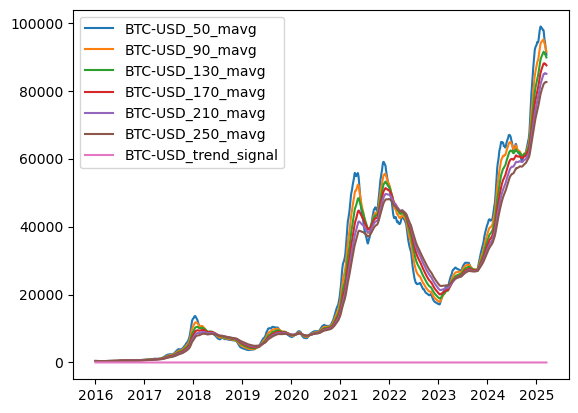

In [603]:
df_trend[mavg_col_list].plot()

<Axes: >

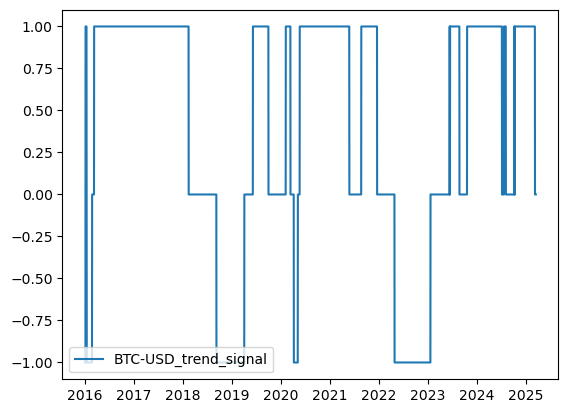

In [605]:
df_trend[[f'{ticker}_trend_signal']].plot()

In [607]:
def calculate_donchian_channels_timestamp(ticker_list):
    start_date = '2021-06-01'
    end_date = '2025-02-27'
    rolling_donchian_window = 20
    ticker_dict = {}
    start_date = pd.to_datetime(start_date).date()
    end_date = pd.to_datetime(end_date).date()
    for ticker in ticker_list:
        df = load_coinbase_timestamp_price_pickle_file(ticker)
        open_price_col = f'{ticker}_8am_open_price'
        
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_price'] = (
            df[open_price_col].rolling(window=rolling_donchian_window).max())
    
        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_price'] = (
            df[open_price_col].rolling(window=rolling_donchian_window).min())
    
        # Middle of the channel (optional, could be just average of upper and lower)
        df[f'{ticker}_{rolling_donchian_window}_donchian_middle_band_price'] = (
                (df[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_price'] +
                 df[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_price']) / 2)
    
        # Shift only the Keltner channel metrics to avoid look-ahead bias
        df[[f'{ticker}_{rolling_donchian_window}_donchian_middle_band_price',
            f'{ticker}_{rolling_donchian_window}_donchian_upper_band_price',
            f'{ticker}_{rolling_donchian_window}_donchian_lower_band_price']] = df[[
            f'{ticker}_{rolling_donchian_window}_donchian_middle_band_price',
            f'{ticker}_{rolling_donchian_window}_donchian_upper_band_price',
            f'{ticker}_{rolling_donchian_window}_donchian_lower_band_price']].shift(1)

        # Donchian Buy signal: Price crosses above upper band
        # Donchian Sell signal: Price crosses below lower band
        donchian_signal_col = f'{ticker}_{rolling_donchian_window}_donchian_signal'
        df[donchian_signal_col] = np.where(
            (df[open_price_col] > df[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_price']), 1,
            np.where((df[open_price_col] < df[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_price']),
                     -1, 0))

        ticker_dict[ticker] = df

    df_final = pd.concat(ticker_dict, axis=1)
    df_final.columns = df_final.columns.droplevel(level=0)

    return df_final

In [609]:
df_donchian = calculate_donchian_channels_timestamp(ticker_list)

In [611]:
df_donchian.head(200)

BTC-USD_8am_open_price  BTC-USD_8am_close_price  \
2016-01-02                  433.85                   433.85   
2016-01-03                  431.68                   431.62   
2016-01-04                  432.60                   432.74   
2016-01-05                  430.01                   430.01   
2016-01-06                  432.42                   432.42   
2016-01-07                  455.21                   455.22   
2016-01-08                  457.00                   456.99   
2016-01-09                  451.01                   451.01   
2016-01-10                  443.94                   443.94   
2016-01-11                  447.46                   447.52   
2016-01-12                  446.80                   446.80   
2016-01-13                  428.04                   428.03   
2016-01-14                  431.97                   431.97   
2016-01-16                  368.83                   369.16   
2016-01-19                  382.92                   382.50   
2016-01-20                  389.00                   389.07   
2016-01-21                  413.58                   413.59   
2016-01-22                  393.33                   393.50   
2016-01-23                  384.76                   384.96   
2016-01-25                  398.66                   398.25   
2016-01-26                  395.00                   394.95   
2016-01-27                  393.99                   393.99   
2016-01-28                  383.03                   383.20   
2016-01-29                  383.45                   383.50   
2016-01-30                  378.54                   378.51   
2016-01-31                  381.65                   381.66   
2016-02-01                  376.00                   376.00   
2016-02-02                  371.77                   371.81   
2016-02-03                  371.36                   371.15   
2016-02-04                  372.51                   372.66   
2016-02-05                  388.71                   388.73   
2016-02-06                  376.17                   376.15   
2016-02-08                  376.82                   376.82   
2016-02-09                  372.49                   372.50   
2016-02-10                  377.07                   377.10   
2016-02-11                  376.55                   376.55   
2016-02-12                  381.31                   381.31   
2016-02-13                  388.54                   388.56   
2016-02-14                  398.35                   398.35   
2016-02-15                  402.86                   402.64   
2016-02-16                  402.59                   402.59   
2016-02-17                  415.40                   415.31   
2016-02-18                  423.10                   423.10   
2016-02-19                  419.77                   419.58   
2016-02-20                  432.54                   432.55   
2016-02-21                  429.16                   429.00   
2016-02-22                  435.76                   435.77   
2016-02-23                  421.85                   421.40   
2016-02-24                  420.92                   420.94   
2016-02-25                  420.05                   420.14   
2016-02-27                  431.41                   431.40   
2016-02-28                  428.66                   428.66   
2016-02-29                  436.51                   436.00   
2016-03-01                  433.36                   433.63   
2016-03-02                  430.97                   431.09   
2016-03-03                  421.05                   421.08   
2016-03-05                  397.38                   397.60   
2016-03-06                  402.89                   402.94   
2016-03-07                  409.65                   409.83   
2016-03-08                  409.43                   409.41   
2016-03-09                  411.17                   411.27   
2016-03-10                  413.08                   413.07   
2016-03-11                  420.03         

In [613]:
def get_trend_donchian_signal_for_portfolio_timestamp(ticker_list, fast_mavg=50, mavg_stepsize=6, slow_mavg=250, rolling_donchian_window=20, long_only=True):

    df_trend = create_trend_strategy_timestamp(ticker_list)
    df_donchian = calculate_donchian_channels_timestamp(ticker_list)

    donchian_cols = []
    for ticker in ticker_list:
        cols = [f'{ticker}_{rolling_donchian_window}_donchian_upper_band_price', f'{ticker}_{rolling_donchian_window}_donchian_lower_band_price',
                f'{ticker}_{rolling_donchian_window}_donchian_middle_band_price', f'{ticker}_{rolling_donchian_window}_donchian_signal']
        donchian_cols.extend(cols)
    df_final = pd.merge(df_trend, df_donchian[donchian_cols], left_index=True, right_index=True, how='left')
    
    for ticker in ticker_list:
        strategy_signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
        strategy_trades_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'
        donchian_signal_col = f'{ticker}_{rolling_donchian_window}_donchian_signal'
        trend_signal_col = f'{ticker}_trend_signal'
        
        # Trend and Donchian Channel Signal
        buy_signal = ((df_final[donchian_signal_col] == 1) &
                      (df_final[trend_signal_col] == 1))
        sell_signal = ((df_final[donchian_signal_col] == -1) &
                       (df_final[trend_signal_col] == -1))
        
        # Generate Long Only Signal
        if long_only:
            df_final[strategy_signal_col] = np.where(buy_signal, 1, 0)
        # Generate Long & Short Signal
        else:
            df_final[strategy_signal_col] = np.where(buy_signal, 1, np.where(sell_signal, -1, 0))

        df_final[strategy_trades_col] = df_final[strategy_signal_col].diff()

    return df_final

In [615]:
df_trend = get_trend_donchian_signal_for_portfolio_timestamp(ticker_list)

In [617]:
print(df_trend.shape)

(3344, 68)


In [385]:
donchian_cond = (df_trend['BTC-USD_8am_open_price'] >= df_trend['BTC-USD_20_donchian_upper_band_price'])
df_trend[donchian_cond].head(200)

BTC-USD_8am_open_price  BTC-USD_8am_close_price  \
2021-07-26                38515.84                 38576.76   
2021-07-28                40787.56                 40722.62   
2021-07-31                41605.66                 41532.19   
2021-08-01                41610.31                 41563.61   
2021-08-07                43853.68                 43806.97   
2021-08-08                44486.15                 44500.56   
2021-08-09                45981.76                 45835.41   
2021-08-13                46170.99                 46187.46   
2021-08-14                46603.67                 46539.07   
2021-08-16                47554.30                 47536.65   
2021-08-21                48554.70                 48569.43   
2021-08-22                49169.36                 49229.54   
2021-08-23                50431.56                 50454.99   
2021-09-06                51424.21                 51310.47   
2021-10-05                49906.08                 49934.97   
2021-10-06                51337.76                 51333.82   
2021-10-07                54331.50                 54335.79   
2021-10-08                55264.97                 55181.20   
2021-10-11                56423.18                 56391.93   
2021-10-12                57258.25                 57301.82   
2021-10-14                57627.26                 57530.88   
2021-10-15                59540.51                 59529.32   
2021-10-16                61593.11                 61550.63   
2021-10-19                62142.78                 62065.11   
2021-10-20                63806.44                 63819.10   
2021-10-21                64809.74                 64887.21   
2021-11-08                65840.36                 65900.00   
2021-11-09                67573.84                 67585.90   
2021-12-24                51049.99                 51007.60   
2021-12-27                51150.00                 51174.86   
2022-02-07                42669.90                 42656.22   
2022-02-08                43493.19                 43441.24   
2022-02-09                44173.33                 44092.85   
2022-02-10                44848.10                 44822.60   
2022-03-25                44617.58                 44649.04   
2022-03-28                47281.77                 47304.62   
2022-03-29                47921.48                 47874.40   
2022-05-31                31755.30                 31741.58   
2022-07-18                22128.33                 22131.80   
2022-07-20                23732.18                 23737.18   
2022-07-30                23965.20                 23959.35   
2022-08-08                24171.37                 24157.62   
2022-08-11                24569.77                 24599.29   
2022-08-14                24571.87                 24564.18   
2022-09-12                22316.71                 22307.38   
2022-09-13                22528.95                 22561.79   
2022-10-06                20247.52                 20243.26   
2022-10-26                20611.46                 20604.52   
2022-10-27                20624.99                 20604.86   
2022-10-29                20706.09                 20695.29   
2022-10-30                20776.20                 20768.71   
2022-11-05                21406.01                 21411.41   
2022-12-05                17256.50                 17255.77   
2022-12-09                17256.79                 17268.37   
2022-12-13                17428.38                 17420.33   
2022-12-14                17909.99                 17907.34   
2023-01-07                16912.17                 16910.79   
2023-01-08                16922.81                 16921.20   
2023-01-09                17247.42                 17248.46   
2023-01-11                17417.82                 17420.76   
2023-01-12                18268.47                 18261.81   
2023-01-13                18862.68                 18866.69   
2023-01-14                20915.34         

In [387]:
df_trend.head(200)

BTC-USD_8am_open_price  BTC-USD_8am_close_price  \
2021-06-01                36601.20                 36545.54   
2021-06-02                37204.26                 37242.00   
2021-06-03                38791.36                 38811.27   
2021-06-04                36587.77                 36403.02   
2021-06-05                35915.26                 35821.11   
2021-06-06                35893.44                 35858.47   
2021-06-07                36395.00                 36424.28   
2021-06-08                33123.94                 33153.76   
2021-06-09                35017.72                 35199.99   
2021-06-10                37843.96                 37787.97   
2021-06-11                37398.31                 37392.39   
2021-06-12                35636.11                 35573.63   
2021-06-13                35912.53                 35908.93   
2021-06-14                39166.16                 39145.10   
2021-06-15                39838.74                 39869.49   
2021-06-16                39092.65                 39023.92   
2021-06-17                39153.79                 39101.91   
2021-06-18                37834.11                 37926.58   
2021-06-19                35945.91                 35897.63   
2021-06-20                33876.49                 33947.02   
2021-06-21                32531.62                 32715.10   
2021-06-22                31213.87                 31160.34   
2021-06-23                33936.06                 33877.01   
2021-06-24                33853.52                 33925.97   
2021-06-25                33324.34                 33355.37   
2021-06-26                31787.98                 31768.49   
2021-06-27                33254.78                 33223.11   
2021-06-28                34116.30                 34041.17   
2021-06-29                35575.65                 35636.62   
2021-06-30                34862.17                 34845.17   
2021-07-01                33713.23                 33670.02   
2021-07-02                33020.34                 33036.35   
2021-07-03                34611.38                 34587.20   
2021-07-04                35522.04                 35502.76   
2021-07-05                33390.01                 33437.66   
2021-07-06                34081.07                 33875.01   
2021-07-07                34847.62                 34850.34   
2021-07-08                32709.40                 32657.08   
2021-07-09                32785.89                 32796.64   
2021-07-10                33796.36                 33781.07   
2021-07-11                33828.57                 33869.83   
2021-07-12                33538.18                 33551.67   
2021-07-13                33046.91                 32992.29   
2021-07-14                32459.92                 32482.45   
2021-07-15                31871.41                 31903.95   
2021-07-16                31083.29                 31114.76   
2021-07-17                31403.05                 31368.24   
2021-07-18                31810.98                 31823.40   
2021-07-19                31270.40                 31218.90   
2021-07-20                29706.00                 29728.90   
2021-07-21                31557.67                 31533.32   
2021-07-22                31921.90                 31899.95   
2021-07-23                32318.01                 32304.49   
2021-07-24                33902.05                 33855.54   
2021-07-25                34420.67                 34362.05   
2021-07-26                38515.84                 38576.76   
2021-07-27                38096.56                 37976.48   
2021-07-28                40787.56                 40722.62   
2021-07-29                39786.70                 39685.43   
2021-07-30                38668.48                 38651.20   
2021-07-31                41605.66                 41532.19   
2021-08-01                41610.31                 41563.61   
2021-08-02                39553.25         

In [619]:
def get_returns_volatility_timestamp(df, vol_range_list=[10], ticker='BTC-USD'):
    df[f'{ticker}_pct_returns'] = df[f'{ticker}_8am_open_price'].pct_change()
    for vol_range in vol_range_list:
        df[f'{ticker}_volatility_{vol_range}'] = df[f'{ticker}_pct_returns'].rolling(vol_range).std()

    return df

In [621]:
def get_volatility_adjusted_trend_signal_timestamp(df, ticker_list, volatility_window=20, fast_mavg=50, mavg_stepsize=6, slow_mavg=250,
                                                   rolling_donchian_window=20, annual_trading_days=365):
    ticker_signal_dict = {}
    final_cols = []
    for ticker in ticker_list:
        trend_signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
        trend_returns_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'
        trend_trades_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'
        donchian_upper_band_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_price'
        donchian_lower_band_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_price'
        annualized_volatility_col = f'{ticker}_annualized_volatility_{volatility_window}'
        vol_adj_trend_signal_col = f'{ticker}_vol_adjusted_trend_signal'

        ## Calculate Position Volatility Adjusted Trend Signal
        df = get_returns_volatility_timestamp(df, vol_range_list=[volatility_window], ticker=f'{ticker}')
        df[annualized_volatility_col] = (df[f'{ticker}_volatility_{volatility_window}'] * np.sqrt(annual_trading_days))
        df[vol_adj_trend_signal_col] = (df[trend_signal_col] / df[annualized_volatility_col])
        df[vol_adj_trend_signal_col] = df[vol_adj_trend_signal_col].fillna(0)
        df[f'{ticker}_t_1_8am_close'] = df[f'{ticker}_8am_close_price'].shift(1)
        trend_cols = [f'{ticker}_8am_open_price', f'{ticker}_8am_close_price', f'{ticker}_t_1_8am_close', f'{ticker}_pct_returns', trend_signal_col,
                      trend_trades_col, donchian_lower_band_col, donchian_upper_band_col, annualized_volatility_col, vol_adj_trend_signal_col]
        final_cols.append(trend_cols)
        ticker_signal_dict[ticker] = df[trend_cols]
    df_signal = pd.concat(ticker_signal_dict, axis=1)

    ## Assign new column names to the dataframe
    df_signal.columns = df_signal.columns.to_flat_index()
    final_cols = [item for sublist in final_cols for item in sublist]
    df_signal.columns = final_cols

    ## Normalize the weights of each position by the total weight of the portfolio
    vol_normalized_signal_cols = [f'{ticker}_vol_adjusted_trend_signal' for ticker in ticker_list]
    df_signal[vol_normalized_signal_cols] = df_signal[vol_normalized_signal_cols].fillna(0)
    for ticker in ticker_list:
        df_signal[f'{ticker}_position_volatility_adjusted_weight'] = (df_signal[f'{ticker}_vol_adjusted_trend_signal'] /
                                                                      df_signal[vol_normalized_signal_cols].abs()
                                                                      .sum(axis=1))
        df_signal[f'{ticker}_position_volatility_adjusted_weight'] = df_signal[
            f'{ticker}_position_volatility_adjusted_weight'].fillna(0)

    return df_signal

In [623]:
df_signal = get_volatility_adjusted_trend_signal_timestamp(df_trend, ticker_list)

In [629]:
# Function to calculate position sizes based on target volatility
def get_target_volatility_position_sizing_timestamp(df, cov_matrix, date, ticker_list, daily_target_volatility,
                                                    total_portfolio_value_upper_limit):
    ## Scale weights of positions to ensure the portfolio is in line with the target volatility
    unscaled_weight_cols = [f'{ticker}_position_volatility_adjusted_weight' for ticker in ticker_list]
    scaled_weight_cols = [f'{ticker}_target_vol_normalized_weight' for ticker in ticker_list]
    target_notional_cols = [f'{ticker}_target_notional' for ticker in ticker_list]
    t_1_price_cols = [f'{ticker}_t_1_8am_close' for ticker in ticker_list]
    open_price_cols = [f'{ticker}_8am_open_price' for ticker in ticker_list]

    if date not in df.index or date not in cov_matrix.index:
        raise ValueError(f"Date {date} not found in DataFrame or covariance matrix index.")

    ## Iterate through each day and calculate the covariance matrix, portfolio volatility and scaling factors
    daily_weights = np.abs(df.loc[date, unscaled_weight_cols].values)
    daily_cov_matrix = cov_matrix.loc[date].values
    daily_portfolio_volatility = size.calculate_portfolio_volatility(daily_weights, daily_cov_matrix)
    df.loc[date, 'daily_portfolio_volatility'] = daily_portfolio_volatility
    if daily_portfolio_volatility > 0:
        scaling_factor = daily_target_volatility / daily_portfolio_volatility
    else:
        scaling_factor = 0
    df.loc[date, 'target_vol_scaling_factor'] = scaling_factor

    # Scale the weights to target volatility
    scaled_weights = daily_weights * scaling_factor
    df.loc[date, scaled_weight_cols] = scaled_weights

    ## Calculate the target notional and size
    target_notionals = scaled_weights * total_portfolio_value_upper_limit
    df.loc[date, target_notional_cols] = target_notionals
    # target_sizes = target_notionals / df.loc[date, t_1_price_cols].values
    target_sizes = target_notionals / df.loc[date, open_price_cols].values

    for i, ticker in enumerate(ticker_list):
        df.loc[date, f'{ticker}_target_size'] = target_sizes[i]

    total_target_notional = target_notionals.sum()
    df.loc[date, 'total_target_notional'] = total_target_notional

    ## Check if the Target Notional is greater than the portfolio value
    if total_target_notional > total_portfolio_value_upper_limit:
        target_notional_scaling_factor = total_portfolio_value_upper_limit / total_target_notional
        df.loc[date, 'target_notional_scaling_factor'] = target_notional_scaling_factor
        adjusted_target_notionals = target_notionals * target_notional_scaling_factor
        df.loc[date, target_notional_cols] = adjusted_target_notionals

        # adjusted_target_sizes = adjusted_target_notionals / df.loc[date, t_1_price_cols].values
        adjusted_target_sizes = adjusted_target_notionals / df.loc[date, open_price_cols].values
        for i, ticker in enumerate(ticker_list):
            df.loc[date, f'{ticker}_target_size'] = adjusted_target_sizes[i]

        df.loc[date, 'total_target_notional'] = adjusted_target_notionals.sum()

    return df

In [685]:
df_final.head(200)

BTC-USD_20_donchian_lower_band_price  \
2016-01-26                                368.83   
2016-01-27                                368.83   
2016-01-28                                368.83   
2016-01-29                                368.83   
2016-01-30                                368.83   
2016-01-31                                368.83   
2016-02-01                                368.83   
2016-02-02                                368.83   
2016-02-03                                368.83   
2016-02-04                                368.83   
2016-02-05                                368.83   
2016-02-06                                368.83   
2016-02-08                                368.83   
2016-02-09                                368.83   
2016-02-10                                371.36   
2016-02-11                                371.36   
2016-02-12                                371.36   
2016-02-13                                371.36   
2016-02-14                                371.36   
2016-02-15                                371.36   
2016-02-16                                371.36   
2016-02-17                                371.36   
2016-02-18                                371.36   
2016-02-19                                371.36   
2016-02-20                                371.36   
2016-02-21                                371.36   
2016-02-22                                371.36   
2016-02-23                                371.36   
2016-02-24                                371.36   
2016-02-25                                372.49   
2016-02-27                                372.49   
2016-02-28                                372.49   
2016-02-29                                372.49   
2016-03-01                                372.49   
2016-03-02                                376.55   
2016-03-03                                376.55   
2016-03-05                                381.31   
2016-03-06                                388.54   
2016-03-07                                397.38   
2016-03-08                                397.38   
2016-03-09                                397.38   
2016-03-10                                397.38   
2016-03-11                                397.38   
2016-03-12                                397.38   
2016-03-13                                397.38   
2016-03-14                                397.38   
2016-03-15                                397.38   
2016-03-16                                397.38   
2016-03-17                                397.38   
2016-03-18                                397.38   
2016-03-19                                397.38   
2016-03-20                                397.38   
2016-03-21                                397.38   
2016-03-22                                397.38   
2016-03-23                                397.38   
2016-03-24                                397.38   
2016-03-25                                397.38   
2016-03-26                                402.89   
2016-03-27                                408.27   
2016-03-28                                408.27   
2016-03-29                                408.27   
2016-03-30                                408.27   
2016-03-31                                408.27   
2016-04-01                                408.27   
2016-04-02                                408.27   
2016-04-03                                408.27   
2016-04-04                                408.27   
2016-04-06                                408.27   
2016-04-07                                408.27   
2016-04-08                                408.27   
2016-04-09                                408.27   
2016-04-10                                408.27   
2016-04-11                                408.27   
2016-04-12                                413.16   
2016-04-13                                413.16   
2016-04-14                                413.16   
2016-04-

In [869]:
date = pd.Timestamp('2016-04-12').date()
previous_date = df_final.index[df_final.index.get_loc(date) - 1]

In [871]:
df_final.loc[previous_date]

BTC-USD_20_donchian_lower_band_price                             408.27
BTC-USD_20_donchian_upper_band_price                             424.03
BTC-USD_50_6_250_mavg_crossover_20_donchian_signal                    0
BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades         0.0
BTC-USD_8am_close_price                                          420.87
BTC-USD_8am_open_price                                           420.76
BTC-USD_actual_position_entry_price                                 0.0
BTC-USD_actual_position_exit_price                                  0.0
BTC-USD_actual_position_notional                                    0.0
BTC-USD_actual_size                                                 0.0
BTC-USD_annualized_volatility_20                               0.165068
BTC-USD_event                                                  No Event
BTC-USD_pct_returns                                           -0.002962
BTC-USD_position_volatility_adjusted_weight                     

In [881]:
df_final.loc[date]

BTC-USD_20_donchian_lower_band_price                                      413.16
BTC-USD_20_donchian_upper_band_price                                      424.03
BTC-USD_50_6_250_mavg_crossover_20_donchian_signal                             1
BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades                  1.0
BTC-USD_8am_close_price                                                   426.46
BTC-USD_8am_open_price                                                    426.44
BTC-USD_actual_position_entry_price                                       426.44
BTC-USD_actual_position_exit_price                                           0.0
BTC-USD_actual_position_notional                                        13328.55
BTC-USD_actual_size                                                    31.255393
BTC-USD_annualized_volatility_20                                        0.154553
BTC-USD_event                                                  New Long Position
BTC-USD_pct_returns         

In [885]:
df.loc[date]

BTC-USD_20_donchian_lower_band_price                              413.16
BTC-USD_20_donchian_upper_band_price                              424.03
BTC-USD_50_6_250_mavg_crossover_20_donchian_signal                     1
BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades          1.0
BTC-USD_8am_close_price                                           426.46
BTC-USD_8am_open_price                                            426.44
BTC-USD_actual_position_entry_price                                  0.0
BTC-USD_actual_position_exit_price                                   0.0
BTC-USD_actual_position_notional                                     0.0
BTC-USD_actual_size                                                  0.0
BTC-USD_annualized_volatility_20                                0.154553
BTC-USD_event                                                   No Event
BTC-USD_pct_returns                                             0.013499
BTC-USD_position_volatility_adjusted_weight        

In [861]:
15000*0.9

13500.0

In [889]:
df = df_final.copy()
date = pd.Timestamp('2016-04-12').date()
ticker = 'BTC-USD'
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20
t_1_close_price_col = f'{ticker}_t_1_8am_close'
open_price_col = f'{ticker}_8am_open_price'
close_price_col = f'{ticker}_8am_close_price'
signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
target_position_notional_col = f'{ticker}_target_notional'
target_position_size_col = f'{ticker}_target_size'
actual_position_notional_col = f'{ticker}_actual_position_notional'
actual_position_size_col = f'{ticker}_actual_size'
actual_position_entry_price_col = f'{ticker}_actual_position_entry_price'
actual_position_exit_price_col = f'{ticker}_actual_position_exit_price'
short_sale_proceeds_col = f'{ticker}_short_sale_proceeds'
upper_donchian_band_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_price'
lower_donchian_band_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_price'
stop_loss_col = f'{ticker}_stop_loss'
event_col = f'{ticker}_event'
df[actual_position_notional_col].loc[date] = 0.0
df[actual_position_entry_price_col].loc[date] = 0.0
df[actual_position_size_col].loc[date] = 0.0
df[event_col].loc[date] = np.nan

## Taking a New Long position
if ((df[signal_col].loc[date] == 1) and
    ((df[signal_col].loc[previous_date] == 0) or (df[event_col].loc[previous_date] == 'No Event')) and
    (df[actual_position_notional_col].loc[previous_date] == 0)):
    print('New Long Position Pass')
    # Building a cash buffer
    available_cash_buffer = df['available_cash'].loc[date] * (1 - 0.10)
    target_long_notional = df[target_position_notional_col].loc[date]
    if ((available_cash_buffer - target_long_notional > 0) and
        (df[upper_donchian_band_col].loc[date] > 0)):
        print(f'Target Long Notional: {target_long_notional}')
        print(f'Available Cash Buffer: {available_cash_buffer}')
        net_long_notional = target_long_notional * (1 - est_fees)
        df[actual_position_notional_col].loc[date] = net_long_notional
        # df[actual_position_entry_price_col].loc[date] = df[t_1_close_price_col].loc[date]
        df[actual_position_entry_price_col].loc[date] = df[open_price_col].loc[date]
        df[actual_position_size_col].loc[date] = (df[actual_position_notional_col].loc[date] /
                                                  df[actual_position_entry_price_col].loc[date])
        df['available_cash'].loc[date] = df['available_cash'].loc[date] - target_long_notional
        # df[stop_loss_col].loc[date] = df[upper_donchian_band_col].loc[date]
        df[stop_loss_col].loc[date] = df[open_price_col].loc[date]
        df[event_col].loc[date] = 'New Long Position'
    else:
        df[event_col].loc[date] = 'No Event'

## Taking a New Short position
elif ((df[signal_col].loc[date] == -1) and
      ((df[signal_col].loc[previous_date] == 0) or (df[event_col].loc[previous_date] == 'No Event')) and
      (df[actual_position_notional_col].loc[previous_date] == 0)):
    print('New Short Position Pass')
    # Building a cash buffer
    available_cash_buffer = df['available_cash'].loc[date] * (1 - 0.10)
    target_short_notional = df[target_position_notional_col].loc[date]
    if ((available_cash_buffer - target_short_notional > 0) and
        (df[lower_donchian_band_col].loc[date] > 0)):
        net_short_notional = -(target_short_notional * (1 - est_fees))
        df[actual_position_notional_col].loc[date] = net_short_notional
        # df[actual_position_entry_price_col].loc[date] = df[t_1_close_price_col].loc[date]
        df[actual_position_entry_price_col].loc[date] = df[open_price_col].loc[date]
        df[actual_position_size_col].loc[date] = (df[actual_position_notional_col].loc[date] /
                                                  df[actual_position_entry_price_col].loc[date])
        df[short_sale_proceeds_col].loc[date] = -net_short_notional
        # df[stop_loss_col].loc[date] = df[lower_donchian_band_col].loc[date]
        df[stop_loss_col].loc[date] = df[open_price_col].loc[date]
        df[event_col].loc[date] = 'New Short Position'
    else:
        df[event_col].loc[date] = 'No Event'

## SHOULD THE STOP LOSS HERE BE UPDATED TO THE DONCHIAN BAND
## Open Long Position
elif (df[signal_col].loc[date] == 1) and (df[signal_col].loc[previous_date] == 1) and (
    df[actual_position_notional_col].loc[previous_date] > 0):
    print('Open Long Position Pass')
    df[actual_position_size_col].loc[date] = df[actual_position_size_col].loc[previous_date]
    # df[actual_position_notional_col].loc[date] = (df[actual_position_size_col].loc[date] *
    #                                               df[t_1_close_price_col].loc[date])
    df[actual_position_notional_col].loc[date] = (df[actual_position_size_col].loc[date] *
                                                  df[open_price_col].loc[date])
    df[actual_position_entry_price_col].loc[date] = df[actual_position_entry_price_col].loc[previous_date]
    # df[stop_loss_col].loc[date] = df[stop_loss_col].loc[previous_date]
    # df[stop_loss_col].loc[date] = df[upper_donchian_band_col].loc[date]
    df[stop_loss_col].loc[date] = df[open_price_col].loc[previous_date]
    df[event_col].loc[date] = 'Open Long Position'

## Open Short Position
elif (df[signal_col].loc[date] == -1) and (df[signal_col].loc[previous_date] == -1) and (
    df[actual_position_notional_col].loc[previous_date] < 0):
    print('Open Short Position Pass')
    df[actual_position_size_col].loc[date] = df[actual_position_size_col].loc[previous_date]
    # df[actual_position_notional_col].loc[date] = (df[actual_position_size_col].loc[date] *
    #                                               df[t_1_close_price_col].loc[date])
    df[actual_position_notional_col].loc[date] = (df[actual_position_size_col].loc[date] *
                                                  df[open_price_col].loc[date])
    df[actual_position_entry_price_col].loc[date] = df[actual_position_entry_price_col].loc[previous_date]
    df[short_sale_proceeds_col].loc[date] = df[short_sale_proceeds_col].loc[previous_date]
    # df[stop_loss_col].loc[date] = df[stop_loss_col].loc[previous_date]
    # df[stop_loss_col].loc[date] = df[lower_donchian_band_col].loc[date]
    df[stop_loss_col].loc[date] = df[open_price_col].loc[previous_date]
    df[event_col].loc[date] = 'Open Short Position'

## Taking a New Long Position with an Open Short Position
elif (df[signal_col].loc[date] == 1) and (df[signal_col].loc[previous_date] == -1) and (
    df[actual_position_notional_col].loc[previous_date] < 0):
    print('New Long with Open Short Position Pass')
    target_long_notional = min(df[target_position_notional_col].loc[date], df['available_cash'].loc[date])
    if (target_long_notional > 0) and (df[upper_donchian_band_col].loc[date] > 0):
        net_long_notional = target_long_notional * (1 - est_fees)
        df[actual_position_notional_col].loc[date] = net_long_notional
        # df[actual_position_entry_price_col].loc[date] = df[t_1_close_price_col].loc[date]
        df[actual_position_entry_price_col].loc[date] = df[open_price_col].loc[date]
        df[actual_position_size_col].loc[date] = (df[actual_position_notional_col].loc[date] /
                                                  df[actual_position_entry_price_col].loc[date])
        df[short_sale_proceeds_col].loc[date] = 0.0
        df['available_cash'].loc[date] = df['available_cash'].loc[date] - target_long_notional
        # df[stop_loss_col].loc[date] = df[upper_donchian_band_col].loc[date]
        df[stop_loss_col].loc[date] = df[open_price_col].loc[date]
        df[event_col].loc[date] = 'New Long with Open Short Position'
    else:
        df[event_col].loc[date] = 'No Event'
        # pass

## Taking a New Short Position with an Existing Long Position
elif (df[signal_col].loc[date] == -1) and (df[signal_col].loc[previous_date] == 1) and (
        df[actual_position_notional_col].loc[previous_date] > 0):
    print('New Short with Open Long Position Pass')
    target_short_notional = min(df[target_position_notional_col].loc[date], df['available_cash'].loc[date])
    if (target_short_notional > 0) and (df[lower_donchian_band_col].loc[date] > 0):
        net_short_notional = -(target_short_notional * (1 - est_fees))
        df[actual_position_notional_col].loc[date] = net_short_notional
        # df[actual_position_entry_price_col].loc[date] = df[t_1_close_price_col].loc[date]
        df[actual_position_entry_price_col].loc[date] = df[open_price_col].loc[date]
        df[actual_position_size_col].loc[date] = (df[actual_position_notional_col].loc[date] /
                                                  df[actual_position_entry_price_col].loc[date])
        df[short_sale_proceeds_col].loc[date] = -net_short_notional
        # df[stop_loss_col].loc[date] = df[lower_donchian_band_col].loc[date]
        df[stop_loss_col].loc[date] = df[open_price_col].loc[date]
        df[event_col].loc[date] = 'New Short with Open Long Position'
    else:
        df[event_col].loc[date] = 'No Event'
        # pass

## Closing a Long Position
elif (df[signal_col].loc[date] == 0) and (df[signal_col].loc[previous_date] == 1) and (
    df[actual_position_notional_col].loc[previous_date] > 0):
    print('Closing Long Position Pass')
    df[actual_position_notional_col].loc[date] = 0
    df[actual_position_entry_price_col].loc[date] = 0
    df[actual_position_size_col].loc[date] = 0
    # df[actual_position_exit_price_col].loc[date] = df[t_1_close_price_col].loc[date]
    stop_loss_cond = (df[stop_loss_col].loc[previous_date] >= df[open_price_col].loc[date])
    df[actual_position_exit_price_col].loc[date] = np.where(stop_loss_cond, df[stop_loss_col].loc[previous_date],
                                                            df[open_price_col].loc[date])
    closing_long_market_value = (df[actual_position_size_col].loc[previous_date] *
                                 df[actual_position_exit_price_col].loc[date])
    net_closing_long_market_value = closing_long_market_value * (1 - est_fees)
    df['available_cash'].loc[date] = (df['available_cash'].loc[date] + net_closing_long_market_value)
    df[event_col].loc[date] = 'Closing Long Position'

## Closing a Short Position
elif (df[signal_col].loc[date] == 0) and (df[signal_col].loc[previous_date] == -1) and (
    df[actual_position_notional_col].loc[previous_date] < 0):
    print('Closing Short Position Pass')
    df[actual_position_notional_col].loc[date] = 0
    df[actual_position_entry_price_col].loc[date] = 0
    df[actual_position_size_col].loc[date] = 0
    # df[actual_position_exit_price_col].loc[date] = df[t_1_close_price_col].loc[date]
    stop_loss_cond = (df[stop_loss_col].loc[previous_date] <= df[open_price_col].loc[date])
    df[actual_position_exit_price_col].loc[date] = np.where(stop_loss_cond, df[stop_loss_col].loc[previous_date],
                                                            df[open_price_col].loc[date])
    df[short_sale_proceeds_col].loc[date] = 0.0
    closing_short_market_value = (df[actual_position_size_col].loc[previous_date] *
                                  df[actual_position_exit_price_col].loc[date])
    net_closing_short_market_value = closing_short_market_value * (1 - est_fees)
    short_sale_proceeds = df[short_sale_proceeds_col].loc[previous_date]
    df['available_cash'].loc[date] = (df['available_cash'].loc[date] +
                                      (net_closing_short_market_value + short_sale_proceeds))
    df[event_col].loc[date] = 'Closing Short Position'

## No Event
## TODO: FIX THIS
elif (df[signal_col].loc[date] == 0) and ((df[signal_col].loc[previous_date] == 0) or (df[event_col].loc[previous_date] == 'No Event')):
    print('No Event Pass')
    df[actual_position_notional_col].loc[date] = 0
    df[actual_position_entry_price_col].loc[date] = 0
    df[actual_position_size_col].loc[date] = 0
    df[short_sale_proceeds_col].loc[date] = 0
    df[stop_loss_col].loc[date] = 0
    df[event_col].loc[date] = 'No Event'

New Long Position Pass


In [809]:
def get_daily_positions_and_portfolio_cash_timestamp(df, date, ticker_list, fast_mavg, mavg_stepsize, slow_mavg, rolling_donchian_window,
                                                     transaction_cost_est, passive_trade_rate):

    previous_date = df.index[df.index.get_loc(date) - 1]

    ## Estimated Transaction Costs and Fees
    est_fees = (transaction_cost_est + perf.estimate_fee_per_trade(passive_trade_rate))

    for ticker in ticker_list:
        t_1_close_price_col = f'{ticker}_t_1_8am_close'
        open_price_col = f'{ticker}_8am_open_price'
        close_price_col = f'{ticker}_8am_close_price'
        signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
        target_position_notional_col = f'{ticker}_target_notional'
        target_position_size_col = f'{ticker}_target_size'
        actual_position_notional_col = f'{ticker}_actual_position_notional'
        actual_position_size_col = f'{ticker}_actual_size'
        actual_position_entry_price_col = f'{ticker}_actual_position_entry_price'
        actual_position_exit_price_col = f'{ticker}_actual_position_exit_price'
        short_sale_proceeds_col = f'{ticker}_short_sale_proceeds'
        upper_donchian_band_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_price'
        lower_donchian_band_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_price'
        stop_loss_col = f'{ticker}_stop_loss'
        event_col = f'{ticker}_event'
        df[actual_position_notional_col].loc[date] = 0.0
        df[actual_position_entry_price_col].loc[date] = 0.0
        df[actual_position_size_col].loc[date] = 0.0
        df[event_col].loc[date] = np.nan

        ## Taking a New Long position
        if ((df[signal_col].loc[date] == 1) and
            ((df[signal_col].loc[previous_date] == 0) or (df[event_col].loc[previous_date] == 'No Event')) and
            (df[actual_position_notional_col].loc[previous_date] == 0)):
            # Building a cash buffer
            available_cash_buffer = df['available_cash'].loc[date] * (1 - 0.10)
            target_long_notional = df[target_position_notional_col].loc[date]
            if ((available_cash_buffer - target_long_notional > 0) and
                (df[upper_donchian_band_col].loc[date] > 0)):
                net_long_notional = target_long_notional * (1 - est_fees)
                df[actual_position_notional_col].loc[date] = net_long_notional
                # df[actual_position_entry_price_col].loc[date] = df[t_1_close_price_col].loc[date]
                df[actual_position_entry_price_col].loc[date] = df[open_price_col].loc[date]
                df[actual_position_size_col].loc[date] = (df[actual_position_notional_col].loc[date] /
                                                          df[actual_position_entry_price_col].loc[date])
                df['available_cash'].loc[date] = df['available_cash'].loc[date] - target_long_notional
                # df[stop_loss_col].loc[date] = df[upper_donchian_band_col].loc[date]
                df[stop_loss_col].loc[date] = df[open_price_col].loc[date]
                df[event_col].loc[date] = 'New Long Position'
            else:
                df[event_col].loc[date] = 'No Event'

        ## Taking a New Short position
        elif ((df[signal_col].loc[date] == -1) and
              ((df[signal_col].loc[previous_date] == 0) or (df[event_col].loc[previous_date] == 'No Event')) and
              (df[actual_position_notional_col].loc[previous_date] == 0)):
            # Building a cash buffer
            available_cash_buffer = df['available_cash'].loc[date] * (1 - 0.10)
            target_short_notional = df[target_position_notional_col].loc[date]
            if ((available_cash_buffer - target_short_notional > 0) and
                (df[lower_donchian_band_col].loc[date] > 0)):
                net_short_notional = -(target_short_notional * (1 - est_fees))
                df[actual_position_notional_col].loc[date] = net_short_notional
                # df[actual_position_entry_price_col].loc[date] = df[t_1_close_price_col].loc[date]
                df[actual_position_entry_price_col].loc[date] = df[open_price_col].loc[date]
                df[actual_position_size_col].loc[date] = (df[actual_position_notional_col].loc[date] /
                                                          df[actual_position_entry_price_col].loc[date])
                df[short_sale_proceeds_col].loc[date] = -net_short_notional
                # df[stop_loss_col].loc[date] = df[lower_donchian_band_col].loc[date]
                df[stop_loss_col].loc[date] = df[open_price_col].loc[date]
                df[event_col].loc[date] = 'New Short Position'
            else:
                df[event_col].loc[date] = 'No Event'

        ## SHOULD THE STOP LOSS HERE BE UPDATED TO THE DONCHIAN BAND
        ## Open Long Position
        elif (df[signal_col].loc[date] == 1) and (df[signal_col].loc[previous_date] == 1) and (
                df[actual_position_notional_col].loc[previous_date] > 0):
            df[actual_position_size_col].loc[date] = df[actual_position_size_col].loc[previous_date]
            # df[actual_position_notional_col].loc[date] = (df[actual_position_size_col].loc[date] *
            #                                               df[t_1_close_price_col].loc[date])
            df[actual_position_notional_col].loc[date] = (df[actual_position_size_col].loc[date] *
                                                          df[open_price_col].loc[date])
            df[actual_position_entry_price_col].loc[date] = df[actual_position_entry_price_col].loc[previous_date]
            # df[stop_loss_col].loc[date] = df[stop_loss_col].loc[previous_date]
            # df[stop_loss_col].loc[date] = df[upper_donchian_band_col].loc[date]
            df[stop_loss_col].loc[date] = df[open_price_col].loc[previous_date]
            df[event_col].loc[date] = 'Open Long Position'

        ## Open Short Position
        elif (df[signal_col].loc[date] == -1) and (df[signal_col].loc[previous_date] == -1) and (
            df[actual_position_notional_col].loc[previous_date] < 0):
            df[actual_position_size_col].loc[date] = df[actual_position_size_col].loc[previous_date]
            # df[actual_position_notional_col].loc[date] = (df[actual_position_size_col].loc[date] *
            #                                               df[t_1_close_price_col].loc[date])
            df[actual_position_notional_col].loc[date] = (df[actual_position_size_col].loc[date] *
                                                          df[open_price_col].loc[date])
            df[actual_position_entry_price_col].loc[date] = df[actual_position_entry_price_col].loc[previous_date]
            df[short_sale_proceeds_col].loc[date] = df[short_sale_proceeds_col].loc[previous_date]
            # df[stop_loss_col].loc[date] = df[stop_loss_col].loc[previous_date]
            # df[stop_loss_col].loc[date] = df[lower_donchian_band_col].loc[date]
            df[stop_loss_col].loc[date] = df[open_price_col].loc[previous_date]
            df[event_col].loc[date] = 'Open Short Position'

        ## Taking a New Long Position with an Open Short Position
        elif (df[signal_col].loc[date] == 1) and (df[signal_col].loc[previous_date] == -1) and (
                df[actual_position_notional_col].loc[previous_date] < 0):
            target_long_notional = min(df[target_position_notional_col].loc[date], df['available_cash'].loc[date])
            if (target_long_notional > 0) and (df[upper_donchian_band_col].loc[date] > 0):
                net_long_notional = target_long_notional * (1 - est_fees)
                df[actual_position_notional_col].loc[date] = net_long_notional
                # df[actual_position_entry_price_col].loc[date] = df[t_1_close_price_col].loc[date]
                df[actual_position_entry_price_col].loc[date] = df[open_price_col].loc[date]
                df[actual_position_size_col].loc[date] = (df[actual_position_notional_col].loc[date] /
                                                          df[actual_position_entry_price_col].loc[date])
                df[short_sale_proceeds_col].loc[date] = 0.0
                df['available_cash'].loc[date] = df['available_cash'].loc[date] - target_long_notional
                # df[stop_loss_col].loc[date] = df[upper_donchian_band_col].loc[date]
                df[stop_loss_col].loc[date] = df[open_price_col].loc[date]
                df[event_col].loc[date] = 'New Long with Open Short Position'
            else:
                df[event_col].loc[date] = 'No Event'
                # pass

        ## Taking a New Short Position with an Existing Long Position
        elif (df[signal_col].loc[date] == -1) and (df[signal_col].loc[previous_date] == 1) and (
                df[actual_position_notional_col].loc[previous_date] > 0):
            target_short_notional = min(df[target_position_notional_col].loc[date], df['available_cash'].loc[date])
            if (target_short_notional > 0) and (df[lower_donchian_band_col].loc[date] > 0):
                net_short_notional = -(target_short_notional * (1 - est_fees))
                df[actual_position_notional_col].loc[date] = net_short_notional
                # df[actual_position_entry_price_col].loc[date] = df[t_1_close_price_col].loc[date]
                df[actual_position_entry_price_col].loc[date] = df[open_price_col].loc[date]
                df[actual_position_size_col].loc[date] = (df[actual_position_notional_col].loc[date] /
                                                          df[actual_position_entry_price_col].loc[date])
                df[short_sale_proceeds_col].loc[date] = -net_short_notional
                # df[stop_loss_col].loc[date] = df[lower_donchian_band_col].loc[date]
                df[stop_loss_col].loc[date] = df[open_price_col].loc[date]
                df[event_col].loc[date] = 'New Short with Open Long Position'
            else:
                df[event_col].loc[date] = 'No Event'
                # pass

        ## Closing a Long Position
        elif (df[signal_col].loc[date] == 0) and (df[signal_col].loc[previous_date] == 1) and (
                df[actual_position_notional_col].loc[previous_date] > 0):
            df[actual_position_notional_col].loc[date] = 0
            df[actual_position_entry_price_col].loc[date] = 0
            df[actual_position_size_col].loc[date] = 0
            # df[actual_position_exit_price_col].loc[date] = df[t_1_close_price_col].loc[date]
            stop_loss_cond = (df[stop_loss_col].loc[previous_date] >= df[open_price_col].loc[date])
            df[actual_position_exit_price_col].loc[date] = np.where(stop_loss_cond, df[stop_loss_col].loc[previous_date],
                                                                    df[open_price_col].loc[date])
            closing_long_market_value = (df[actual_position_size_col].loc[previous_date] *
                                         df[actual_position_exit_price_col].loc[date])
            net_closing_long_market_value = closing_long_market_value * (1 - est_fees)
            df['available_cash'].loc[date] = (df['available_cash'].loc[date] + net_closing_long_market_value)
            df[event_col].loc[date] = 'Closing Long Position'

        ## Closing a Short Position
        elif (df[signal_col].loc[date] == 0) and (df[signal_col].loc[previous_date] == -1) and (
                df[actual_position_notional_col].loc[previous_date] < 0):
            df[actual_position_notional_col].loc[date] = 0
            df[actual_position_entry_price_col].loc[date] = 0
            df[actual_position_size_col].loc[date] = 0
            # df[actual_position_exit_price_col].loc[date] = df[t_1_close_price_col].loc[date]
            stop_loss_cond = (df[stop_loss_col].loc[previous_date] <= df[open_price_col].loc[date])
            df[actual_position_exit_price_col].loc[date] = np.where(stop_loss_cond, df[stop_loss_col].loc[previous_date],
                                                                    df[open_price_col].loc[date])
            df[short_sale_proceeds_col].loc[date] = 0.0
            closing_short_market_value = (df[actual_position_size_col].loc[previous_date] *
                                          df[actual_position_exit_price_col].loc[date])
            net_closing_short_market_value = closing_short_market_value * (1 - est_fees)
            short_sale_proceeds = df[short_sale_proceeds_col].loc[previous_date]
            df['available_cash'].loc[date] = (df['available_cash'].loc[date] +
                                              (net_closing_short_market_value + short_sale_proceeds))
            df[event_col].loc[date] = 'Closing Short Position'

        ## No Event
        ## TODO: FIX THIS
        elif (df[signal_col].loc[date] == 0) and ((df[signal_col].loc[previous_date] == 0) or (df[event_col].loc[previous_date] == 'No Event')):
            df[actual_position_notional_col].loc[date] = 0
            df[actual_position_entry_price_col].loc[date] = 0
            df[actual_position_size_col].loc[date] = 0
            df[short_sale_proceeds_col].loc[date] = 0
            df[stop_loss_col].loc[date] = 0
            df[event_col].loc[date] = 'No Event'

    ## Calculate End of Day Portfolio Positions
    actual_position_notional_cols = [f'{ticker}_actual_position_notional' for ticker in ticker_list]
    short_sale_proceeds_cols = [f'{ticker}_short_sale_proceeds' for ticker in ticker_list]
    df['count_of_positions'].loc[date] = df[actual_position_notional_cols].loc[date].ne(0).sum()
    df['total_actual_position_notional'].loc[date] = df[actual_position_notional_cols].loc[date].sum()
    df['total_portfolio_value'].loc[date] = (df['available_cash'].loc[date] +
                                             df[short_sale_proceeds_cols].loc[date].sum() +
                                             df['total_actual_position_notional'].loc[date])

    return df

In [811]:
def get_target_volatility_daily_portfolio_positions_timestamp(df, ticker_list, fast_mavg, slow_mavg, mavg_stepsize,
                                                              rolling_donchian_window, initial_capital, rolling_cov_window,
                                                              cash_buffer_percentage, annualized_target_volatility,
                                                              transaction_cost_est=0.001, passive_trade_rate=0.05,
                                                              annual_trading_days=365, use_specific_start_date=False,
                                                              signal_start_date=None):

    ## Calculate the covariance matrix for tickers in the portfolio
    returns_cols = [f'{ticker}_pct_returns' for ticker in ticker_list]
    cov_matrix = df[returns_cols].rolling(rolling_cov_window).cov(pairwise=True).dropna()

    ## Delete rows prior to the first available date of the covariance matrix
    cov_matrix_start_date = cov_matrix.index[0][0]
    df = df[df.index >= cov_matrix_start_date]

    ## Derive the Daily Target Portfolio Volatility
    daily_target_volatility = annualized_target_volatility / np.sqrt(annual_trading_days)

    ## Reorder dataframe columns
    col_list = []
    for ticker in ticker_list:
        df[f'{ticker}_actual_size'] = 0.0
        df[f'{ticker}_actual_position_notional'] = 0.0
        df[f'{ticker}_short_sale_proceeds'] = 0.0
        df[f'{ticker}_actual_position_entry_price'] = 0.0
        df[f'{ticker}_actual_position_exit_price'] = 0.0
        df[f'{ticker}_target_vol_normalized_weight'] = 0.0
        df[f'{ticker}_target_notional'] = 0.0
        df[f'{ticker}_target_size'] = 0.0
        df[f'{ticker}_stop_loss'] = 0.0
        df[f'{ticker}_event'] = np.nan
    ord_cols = size.reorder_columns_by_ticker(df.columns, ticker_list)
    df = df[ord_cols]

    ## Portfolio Level Cash and Positions are all set to 0
    df['daily_portfolio_volatility'] = 0.0
    df['available_cash'] = 0.0
    df['count_of_positions'] = 0.0
    df['total_actual_position_notional'] = 0.0
    df['total_target_notional'] = 0.0
    df['total_portfolio_value'] = 0.0
    df['total_portfolio_value_upper_limit'] = 0.0
    df['target_vol_scaling_factor'] = 1.0
    df['target_notional_scaling_factor'] = 1.0

    ## Cash and the Total Portfolio Value on Day 1 is the initial capital for the strategy
    if use_specific_start_date:
        start_index_position = df.index.get_loc(signal_start_date)
    else:
        start_index_position = 0
    df['available_cash'][start_index_position] = initial_capital
    df['total_portfolio_value'][start_index_position] = initial_capital

    ## Identify Daily Positions starting from day 2
    for date in df.index[start_index_position + 1:]:
        previous_date = df.index[df.index.get_loc(date) - 1]

        ## Start the day with the available cash from yesterday
        df['available_cash'].loc[date] = df['available_cash'].loc[previous_date]
        total_portfolio_value_upper_limit = (df['total_portfolio_value'].loc[previous_date] *
                                             (1 - cash_buffer_percentage))
        df['total_portfolio_value_upper_limit'].loc[date] = total_portfolio_value_upper_limit

        ## Calculate the target notional by ticker
        df = get_target_volatility_position_sizing_timestamp(df, cov_matrix, date, ticker_list, daily_target_volatility,
                                                             total_portfolio_value_upper_limit)

        ## Get the daily positions
        df = get_daily_positions_and_portfolio_cash_timestamp(df, date, ticker_list, fast_mavg, mavg_stepsize, slow_mavg,
                                                              rolling_donchian_window, transaction_cost_est, passive_trade_rate)

        ## Calculate Portfolio Value and Available Cash
        # df = calculate_portfolio_cash_and_market_value_per_day(df, date, ticker_list, transaction_cost_est,
        #                                                        passive_trade_rate)

    return df

In [813]:
# Calculate Portfolio Returns and Rolling Sharpe Ratio
def calculate_portfolio_returns_timestamp(df, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window,
                                          rolling_sharpe_window):
    ## Calculate Portfolio Returns
    df['portfolio_daily_pct_returns'] = df['total_portfolio_value'].pct_change()
    df['portfolio_daily_pct_returns'].replace([np.inf, -np.inf], 0, inplace=True)
    df['portfolio_daily_pct_returns'] = df['portfolio_daily_pct_returns'].fillna(0)
    trade_cols = [
        f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'
        for ticker in ticker_list]
    df['portfolio_trade_count'] = np.abs(df[trade_cols]).sum(axis=1)
    df['portfolio_strategy_cumulative_return'] = (1 + df['portfolio_daily_pct_returns']).cumprod() - 1

    ## Calculate Rolling Sharpe Ratio
    df[f'rolling_sharpe_{rolling_sharpe_window}'] = (perf.rolling_sharpe_ratio(
        df, window=rolling_sharpe_window, strategy_daily_return_col='portfolio_daily_pct_returns',
        strategy_trade_count_col='portfolio_trade_count', include_transaction_costs_and_fees=False,
        annual_trading_days=365))
    df = df.rename(
        columns={f'rolling_sharpe_{rolling_sharpe_window}': f'portfolio_rolling_sharpe_{rolling_sharpe_window}'})

    return df

In [815]:
# Target Volatility Position Sizing Strategy for a Trend Following Signal
def apply_target_volatility_position_sizing_strategy_timestamp(start_date, end_date, ticker_list, fast_mavg, slow_mavg,
                                                               mavg_stepsize, rolling_donchian_window, long_only=False,
                                                               initial_capital=15000, rolling_cov_window=20, volatility_window=20,
                                                               transaction_cost_est=0.001, passive_trade_rate=0.05,
                                                               use_coinbase_data=True, rolling_sharpe_window=50,
                                                               cash_buffer_percentage=0.10, annualized_target_volatility=0.20,
                                                               annual_trading_days=365, use_specific_start_date=False,
                                                               signal_start_date=None):
    ## Generate Trend Signal for all tickers
    df_trend = get_trend_donchian_signal_for_portfolio_timestamp(ticker_list=ticker_list, fast_mavg=fast_mavg,
                                                                 slow_mavg=slow_mavg,
                                                                 mavg_stepsize=mavg_stepsize,
                                                                 rolling_donchian_window=rolling_donchian_window,
                                                                 long_only=long_only)

    ## Get Volatility Adjusted Trend Signal
    df_signal = get_volatility_adjusted_trend_signal_timestamp(df_trend, ticker_list, volatility_window, fast_mavg, mavg_stepsize,
                                                               slow_mavg, rolling_donchian_window, annual_trading_days)
    
    ## Get Daily Positions
    df = get_target_volatility_daily_portfolio_positions_timestamp(df_signal, ticker_list, fast_mavg, slow_mavg, mavg_stepsize,
                                                                   rolling_donchian_window, initial_capital, rolling_cov_window,
                                                                   cash_buffer_percentage, annualized_target_volatility,
                                                                   transaction_cost_est, passive_trade_rate, annual_trading_days,
                                                                   use_specific_start_date, signal_start_date)

    ## Calculate Portfolio Performance
    df = calculate_portfolio_returns_timestamp(df, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window,
                                               rolling_sharpe_window)

    return df

In [817]:
start_date = '2021-06-01'
end_date = '2025-03-17'
ticker_list = ['BTC-USD']#,'ETH-USD','LTC-USD','SOL-USD']#,'XRP-USD']
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20
long_only=True
volatility_window = 20
annual_trading_days = 365
df_trend = get_trend_donchian_signal_for_portfolio_timestamp(ticker_list=ticker_list, fast_mavg=fast_mavg,
                                                             slow_mavg=slow_mavg,
                                                             mavg_stepsize=mavg_stepsize,
                                                             rolling_donchian_window=rolling_donchian_window,
                                                             long_only=long_only)

df_signal = get_volatility_adjusted_trend_signal_timestamp(df_trend, ticker_list, volatility_window, fast_mavg, mavg_stepsize,
                                                           slow_mavg, rolling_donchian_window, annual_trading_days)

In [819]:
df_trend.head()

BTC-USD_8am_open_price  BTC-USD_8am_close_price  \
2016-01-02                  433.85                   433.85   
2016-01-03                  431.68                   431.62   
2016-01-04                  432.60                   432.74   
2016-01-05                  430.01                   430.01   
2016-01-06                  432.42                   432.42   

            BTC-USD_8am_t_1_close  BTC-USD_pct_returns  BTC-USD_50_mavg  \
2016-01-02                    NaN                  NaN       433.850000   
2016-01-03                 433.85            -0.005002       432.743300   
2016-01-04                 431.62             0.002131       432.693610   
2016-01-05                 432.74            -0.005987       431.981928   
2016-01-06                 430.01             0.005605       432.076689   

            BTC-USD_90_mavg  BTC-USD_130_mavg  BTC-USD_170_mavg  \
2016-01-02       433.850000        433.850000        433.850000   
2016-01-03       432.752944        432.756654        432.758618   
2016-01-04       432.700826        432.703631        432.705122   
2016-01-05       432.005532        432.014604        432.019405   
2016-01-06       432.092150        432.098197        432.101420   

            BTC-USD_210_mavg  BTC-USD_250_mavg  BTC-USD_trend_signal  \
2016-01-02        433.850000        433.850000                    -1   
2016-01-03        432.759833        432.760660                    -1   
2016-01-04        432.706047        432.706678                    -1   
2016-01-05        432.022376        432.024397                    -1   
2016-01-06        432.103423        432.104788                    -1   

            BTC-USD_20_donchian_upper_band_price  \
2016-01-02                                   NaN   
2016-01-03                                   NaN   
2016-01-04                                   NaN   
2016-01-05                                   NaN   
2016-01-06                                   NaN   

            BTC-USD_20_donchian_lower_band_price  \
2016-01-02                                   NaN   
2016-01-03                                   NaN   
2016-01-04                                   NaN   
2016-01-05                                   NaN   
2016-01-06                                   NaN   

            BTC-USD_20_donchian_middle_band_price  BTC-USD_20_donchian_signal  \
2016-01-02                                    NaN                           0   
2016-01-03                                    NaN                           0   
2016-01-04                                    NaN                           0   
2016-01-05                                    NaN                           0   
2016-01-06                                    NaN                           0   

            BTC-USD_50_6_250_mavg_crossover_20_donchian_signal  \
2016-01-02                                                  0    
2016-01-03                                                  0    
2016-01-04                                                  0    
2016-01-05                                                  0    
2016-01-06                                                  0    

            BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades  \
2016-01-02                                                NaN             
2016-01-03                                                0.0             
2016-01-04                                                0.0             
2016-01-05                                                0.0             
2016-01-06                                                0.0             

            BTC-USD_volatility_20  BTC-USD_annualized_volatility_20  \
2016-01-02                    NaN                               NaN   
2016-01-03                    NaN                               NaN   
2016-01-04                    NaN                               NaN   
2016-01-05                    NaN                               NaN   
2016-01-06                    

In [821]:
df_signal.head(200)

BTC-USD_8am_open_price  BTC-USD_8am_close_price  \
2016-01-02                  433.85                   433.85   
2016-01-03                  431.68                   431.62   
2016-01-04                  432.60                   432.74   
2016-01-05                  430.01                   430.01   
2016-01-06                  432.42                   432.42   
2016-01-07                  455.21                   455.22   
2016-01-08                  457.00                   456.99   
2016-01-09                  451.01                   451.01   
2016-01-10                  443.94                   443.94   
2016-01-11                  447.46                   447.52   
2016-01-12                  446.80                   446.80   
2016-01-13                  428.04                   428.03   
2016-01-14                  431.97                   431.97   
2016-01-16                  368.83                   369.16   
2016-01-19                  382.92                   382.50   
2016-01-20                  389.00                   389.07   
2016-01-21                  413.58                   413.59   
2016-01-22                  393.33                   393.50   
2016-01-23                  384.76                   384.96   
2016-01-25                  398.66                   398.25   
2016-01-26                  395.00                   394.95   
2016-01-27                  393.99                   393.99   
2016-01-28                  383.03                   383.20   
2016-01-29                  383.45                   383.50   
2016-01-30                  378.54                   378.51   
2016-01-31                  381.65                   381.66   
2016-02-01                  376.00                   376.00   
2016-02-02                  371.77                   371.81   
2016-02-03                  371.36                   371.15   
2016-02-04                  372.51                   372.66   
2016-02-05                  388.71                   388.73   
2016-02-06                  376.17                   376.15   
2016-02-08                  376.82                   376.82   
2016-02-09                  372.49                   372.50   
2016-02-10                  377.07                   377.10   
2016-02-11                  376.55                   376.55   
2016-02-12                  381.31                   381.31   
2016-02-13                  388.54                   388.56   
2016-02-14                  398.35                   398.35   
2016-02-15                  402.86                   402.64   
2016-02-16                  402.59                   402.59   
2016-02-17                  415.40                   415.31   
2016-02-18                  423.10                   423.10   
2016-02-19                  419.77                   419.58   
2016-02-20                  432.54                   432.55   
2016-02-21                  429.16                   429.00   
2016-02-22                  435.76                   435.77   
2016-02-23                  421.85                   421.40   
2016-02-24                  420.92                   420.94   
2016-02-25                  420.05                   420.14   
2016-02-27                  431.41                   431.40   
2016-02-28                  428.66                   428.66   
2016-02-29                  436.51                   436.00   
2016-03-01                  433.36                   433.63   
2016-03-02                  430.97                   431.09   
2016-03-03                  421.05                   421.08   
2016-03-05                  397.38                   397.60   
2016-03-06                  402.89                   402.94   
2016-03-07                  409.65                   409.83   
2016-03-08                  409.43                   409.41   
2016-03-09                  411.17                   411.27   
2016-03-10                  413.08                   413.07   
2016-03-11                  420.03         

In [897]:
start_date = '2021-06-01'
end_date = '2025-03-17'
ticker_list = ['BTC-USD']#,'ETH-USD','LTC-USD','SOL-USD']#,'XRP-USD']
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20
long_only=True
df_final = apply_target_volatility_position_sizing_strategy_timestamp(start_date, end_date, ticker_list, fast_mavg, slow_mavg,
                                                               mavg_stepsize, rolling_donchian_window, long_only,
                                                               initial_capital=15000, rolling_cov_window=20, volatility_window=20,
                                                               transaction_cost_est=0.001, passive_trade_rate=0.05,
                                                               use_coinbase_data=True, rolling_sharpe_window=50,
                                                               cash_buffer_percentage=0.10, annualized_target_volatility=0.20,
                                                               annual_trading_days=365, use_specific_start_date=False,
                                                               signal_start_date=None)

In [898]:
df_final.tail()

BTC-USD_20_donchian_lower_band_price  \
2025-03-13                              80726.69   
2025-03-14                              80726.69   
2025-03-15                              80726.69   
2025-03-16                              80726.69   
2025-03-17                              80726.69   

            BTC-USD_20_donchian_upper_band_price  \
2025-03-13                              98931.26   
2025-03-14                              96809.07   
2025-03-15                              95802.99   
2025-03-16                              95802.99   
2025-03-17                              92987.96   

            BTC-USD_50_6_250_mavg_crossover_20_donchian_signal  \
2025-03-13                                                  0    
2025-03-14                                                  0    
2025-03-15                                                  0    
2025-03-16                                                  0    
2025-03-17                                                  0    

            BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades  \
2025-03-13                                                0.0             
2025-03-14                                                0.0             
2025-03-15                                                0.0             
2025-03-16                                                0.0             
2025-03-17                                                0.0             

            BTC-USD_8am_close_price  BTC-USD_8am_open_price  \
2025-03-13                 82905.83                82940.63   
2025-03-14                 83194.63                83236.54   
2025-03-15                 84069.14                84118.57   
2025-03-16                 82482.42                82404.39   
2025-03-17                 83729.99                83495.08   

            BTC-USD_actual_position_entry_price  \
2025-03-13                                  0.0   
2025-03-14                                  0.0   
2025-03-15                                  0.0   
2025-03-16                                  0.0   
2025-03-17                                  0.0   

            BTC-USD_actual_position_exit_price  \
2025-03-13                                 0.0   
2025-03-14                                 0.0   
2025-03-15                                 0.0   
2025-03-16                                 0.0   
2025-03-17                                 0.0   

            BTC-USD_actual_position_notional  BTC-USD_actual_size  \
2025-03-13                               0.0                  0.0   
2025-03-14                               0.0                  0.0   
2025-03-15                               0.0                  0.0   
2025-03-16                               0.0                  0.0   
2025-03-17                               0.0                  0.0   

            BTC-USD_annualized_volatility_20 BTC-USD_event  \
2025-03-13                          0.837612      No Event   
2025-03-14                          0.836632      No Event   
2025-03-15                          0.839542      No Event   
2025-03-16                          0.841384      No Event   
2025-03-17                          0.799316      No Event   

            BTC-USD_pct_returns  BTC-USD_position_volatility_adjusted_weight  \
2025-03-13            -0.000412                                          0.0   
2025-03-14             0.003568                                          0.0   
2025-03-15             0.010597                                          0.0   
2025-03-16            -0.020378                                          0.0   
2025-03-17             0.013236                                          0.0   

            BTC-USD_short_sale_proceeds  BTC-USD_stop_loss  \
2025-03-13                          0.0                0.0   
2025-03-14                          0.0                0.0   
2025-03-15                          0.0                0.0   
2025-03-16                        

In [899]:
cols = ['BTC-USD_event','BTC-USD_20_donchian_lower_band_price','BTC-USD_20_donchian_upper_band_price','BTC-USD_50_6_250_mavg_crossover_20_donchian_signal','BTC-USD_8am_open_price','BTC-USD_actual_position_entry_price','BTC-USD_actual_position_exit_price',
       'BTC-USD_stop_loss','BTC-USD_target_notional','BTC-USD_target_size','BTC-USD_actual_position_notional','BTC-USD_actual_size','BTC-USD_pct_returns','total_portfolio_value','portfolio_strategy_cumulative_return']

In [900]:
df_final[df_final['BTC-USD_event'] != 'No Event'][cols].head(200)

BTC-USD_event  BTC-USD_20_donchian_lower_band_price  \
2016-01-26                    NaN                                368.83   
2016-04-12      New Long Position                                413.16   
2016-04-13  Closing Long Position                                413.16   
2016-05-27      New Long Position                                443.33   
2016-05-28     Open Long Position                                443.33   
2016-05-29     Open Long Position                                443.33   
2016-05-30     Open Long Position                                443.33   
2016-05-31     Open Long Position                                443.33   
2016-06-01  Closing Long Position                                443.33   
2016-06-03      New Long Position                                443.33   
2016-06-04     Open Long Position                                443.33   
2016-06-05     Open Long Position                                443.33   
2016-06-06     Open Long Position                                443.33   
2016-06-07     Open Long Position                                443.33   
2016-06-08  Closing Long Position                                443.33   
2016-06-12      New Long Position                                443.79   
2016-06-13     Open Long Position                                446.04   
2016-06-14  Closing Long Position                                450.24   
2016-06-16      New Long Position                                472.99   
2016-06-17     Open Long Position                                492.83   
2016-06-18     Open Long Position                                520.69   
2016-06-19  Closing Long Position                                535.70   
2016-09-04      New Long Position                                568.04   
2016-09-05  Closing Long Position                                568.04   
2016-09-06      New Long Position                                571.70   
2016-09-07     Open Long Position                                571.70   
2016-09-08     Open Long Position                                571.70   
2016-09-09  Closing Long Position                                571.70   
2016-10-07      New Long Position                                596.64   
2016-10-08     Open Long Position                                596.64   
2016-10-09  Closing Long Position                                596.64   
2016-10-27      New Long Position                                616.67   
2016-10-28     Open Long Position                                617.25   
2016-10-29     Open Long Position                                617.25   
2016-10-30     Open Long Position                                617.25   
2016-10-31  Closing Long Position                                628.77   
2016-11-01      New Long Position                                628.77   
2016-11-02  Closing Long Position                                628.77   
2016-11-03      New Long Position                                628.77   
2016-11-04  Closing Long Position                                628.77   
2016-11-16      New Long Position                                683.18   
2016-11-17     Open Long Position                                688.63   
2016-11-18     Open Long Position                                694.66   
2016-11-19     Open Long Position                                694.66   
2016-11-20     Open Long Position                                694.66   
2016-11-21  Closing Long Position                                694.66   
2016-12-01      New Long Position                                694.66   
2016-12-02     Open Long Position                                694.66   
2016-12-03  Closing Long Position                                694.66   
2016-12-08      New Long Position                                730.88   
2016-12-09     Open Long Position                                730.88   
2016-12-10     Open Long Position                                730.88   
2016-12-11  Closing Long Position            

In [901]:
df_final.head(200)

BTC-USD_20_donchian_lower_band_price  \
2016-01-26                                368.83   
2016-01-27                                368.83   
2016-01-28                                368.83   
2016-01-29                                368.83   
2016-01-30                                368.83   
2016-01-31                                368.83   
2016-02-01                                368.83   
2016-02-02                                368.83   
2016-02-03                                368.83   
2016-02-04                                368.83   
2016-02-05                                368.83   
2016-02-06                                368.83   
2016-02-08                                368.83   
2016-02-09                                368.83   
2016-02-10                                371.36   
2016-02-11                                371.36   
2016-02-12                                371.36   
2016-02-13                                371.36   
2016-02-14                                371.36   
2016-02-15                                371.36   
2016-02-16                                371.36   
2016-02-17                                371.36   
2016-02-18                                371.36   
2016-02-19                                371.36   
2016-02-20                                371.36   
2016-02-21                                371.36   
2016-02-22                                371.36   
2016-02-23                                371.36   
2016-02-24                                371.36   
2016-02-25                                372.49   
2016-02-27                                372.49   
2016-02-28                                372.49   
2016-02-29                                372.49   
2016-03-01                                372.49   
2016-03-02                                376.55   
2016-03-03                                376.55   
2016-03-05                                381.31   
2016-03-06                                388.54   
2016-03-07                                397.38   
2016-03-08                                397.38   
2016-03-09                                397.38   
2016-03-10                                397.38   
2016-03-11                                397.38   
2016-03-12                                397.38   
2016-03-13                                397.38   
2016-03-14                                397.38   
2016-03-15                                397.38   
2016-03-16                                397.38   
2016-03-17                                397.38   
2016-03-18                                397.38   
2016-03-19                                397.38   
2016-03-20                                397.38   
2016-03-21                                397.38   
2016-03-22                                397.38   
2016-03-23                                397.38   
2016-03-24                                397.38   
2016-03-25                                397.38   
2016-03-26                                402.89   
2016-03-27                                408.27   
2016-03-28                                408.27   
2016-03-29                                408.27   
2016-03-30                                408.27   
2016-03-31                                408.27   
2016-04-01                                408.27   
2016-04-02                                408.27   
2016-04-03                                408.27   
2016-04-04                                408.27   
2016-04-06                                408.27   
2016-04-07                                408.27   
2016-04-08                                408.27   
2016-04-09                                408.27   
2016-04-10                                408.27   
2016-04-11                                408.27   
2016-04-12                                413.16   
2016-04-13                                413.16   
2016-04-14                                413.16   
2016-04-

In [661]:
df_prices.head()

BTC-USD_8am_open_price  BTC-USD_8am_close_price  \
2016-01-02                  433.85                   433.85   
2016-01-03                  431.68                   431.62   
2016-01-04                  432.60                   432.74   
2016-01-05                  430.01                   430.01   
2016-01-06                  432.42                   432.42   

            BTC-USD_8am_t_1_close  
2016-01-02                    NaN  
2016-01-03                 433.85  
2016-01-04                 431.62  
2016-01-05                 432.74  
2016-01-06                 430.01

<Axes: >

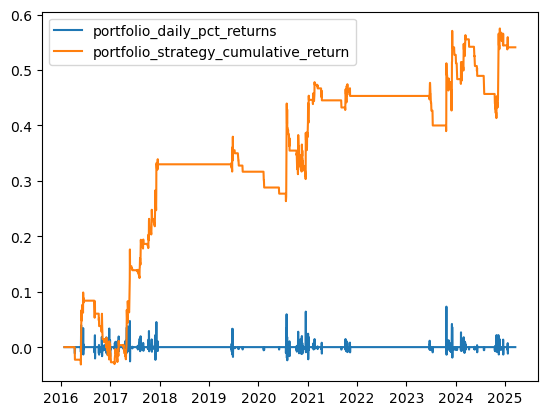

In [907]:
df_final[['portfolio_daily_pct_returns','portfolio_strategy_cumulative_return']].plot()

<Axes: >

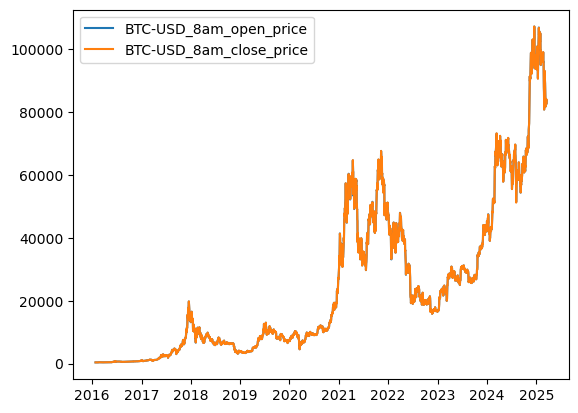

In [655]:
df_final[['BTC-USD_8am_open_price','BTC-USD_8am_close_price']].plot()

In [657]:
df_final_orig[['portfolio_daily_pct_returns']].plot()#,'portfolio_strategy_cumulative_return']].plot()

NameError: name 'df_final_orig' is not defined

In [425]:
perf.calculate_risk_and_performance_metrics(df_final, strategy_daily_return_col='portfolio_daily_pct_returns', strategy_trade_count_col='portfolio_trade_count', include_transaction_costs_and_fees=False, annual_trading_days=365)

{'annualized_return': 0.014312463070337955,
 'annualized_sharpe_ratio': -0.4606240746660184,
 'calmar_ratio': 0.0024172527087810854,
 'annualized_std_dev': 0.06988490051010707,
 'max_drawdown': -5.920962677317715,
 'max_drawdown_duration': Timedelta('610 days 00:00:00'),
 'hit_rate': 0.04673590504451038,
 't_statistic': 0.45655740418399243,
 'p_value': 0.6480628093546147,
 'trade_count': 94.0}

In [455]:
perf.calculate_risk_and_performance_metrics(df_final, strategy_daily_return_col='portfolio_daily_pct_returns', strategy_trade_count_col='portfolio_trade_count', include_transaction_costs_and_fees=False, annual_trading_days=365)

{'annualized_return': 0.19331953787055345,
 'annualized_sharpe_ratio': 1.2466340779235716,
 'calmar_ratio': 0.15278095775752754,
 'annualized_std_dev': 0.10718633159306197,
 'max_drawdown': -1.2653379106142473,
 'max_drawdown_duration': Timedelta('350 days 00:00:00'),
 'hit_rate': 0.14425244177310292,
 't_statistic': 3.249863094460222,
 'p_value': 0.0011834894952592965,
 'trade_count': 506.0}

In [380]:
df_final[df_final['BTC-USD_event'] != 'No Event'].head(200)

BTC-USD_50_6_250_mavg_crossover_20_donchian_signal  \
2021-06-21                                                  0    
2021-08-07                                                  1    
2021-08-08                                                  1    
2021-08-09                                                  1    
2021-08-10                                                  0    
2021-08-13                                                  1    
2021-08-14                                                  1    
2021-08-15                                                  0    
2021-08-16                                                  1    
2021-08-17                                                  0    
2021-08-21                                                  1    
2021-08-22                                                  1    
2021-08-23                                                  1    
2021-08-24                                                  0    
2021-09-06                                                  1    
2021-09-07                                                  0    
2021-10-05                                                  1    
2021-10-06                                                  1    
2021-10-07                                                  1    
2021-10-08                                                  1    
2021-10-09                                                  0    
2021-10-11                                                  1    
2021-10-12                                                  1    
2021-10-13                                                  0    
2021-10-14                                                  1    
2021-10-15                                                  1    
2021-10-16                                                  1    
2021-10-17                                                  0    
2021-10-19                                                  1    
2021-10-20                                                  1    
2021-10-21                                                  1    
2021-10-22                                                  0    
2021-11-08                                                  1    
2021-11-09                                                  1    
2021-11-10                                                  0    
2023-06-21                                                  1    
2023-06-22                                                  1    
2023-06-23                                                  1    
2023-06-24                                                  1    
2023-06-25                                                  1    
2023-06-26                                                  0    
2023-06-27                                                  1    
2023-06-28                                                  0    
2023-06-30                                                  1    
2023-07-01                                                  0    
2023-07-04                                                  1    
2023-07-05                                                  0    
2023-07-14                                                  1    
2023-07-15                                                  0    
2023-10-22                                                  1    
2023-10-23                                                  1    
2023-10-24                                                  1    
2023-10-25                                                  0    
2023-10-30                                                  1    
2023-10-31                                                  0    
2023-11-02                                                  1    
2023-11-03                                                  0    
2023-11-08                                                  1    
2023-11-09                                                  1    
2023-11-10                                          

In [385]:
df_final_orig[df_final_orig['BTC-USD_event'] != 'No Event'].head(200)

BTC-USD  BTC-USD_50_6_250_mavg_crossover_20_donchian_signal  \
date                                                                        
2021-07-01   33516.11                                                  0    
2021-08-06   42869.58                                                  1    
2021-08-07   44637.34                                                  1    
2021-08-08   43829.14                                                  0    
2021-08-09   46285.48                                                  1    
2021-08-10   45595.66                                                  0    
2021-08-13   47833.64                                                  1    
2021-08-14   47109.65                                                  0    
2021-08-20   49342.40                                                  1    
2021-08-21   48867.02                                                  0    
2021-08-23   49506.50                                                  1    
2021-08-24   47682.45                                                  0    
2021-09-03   50025.00                                                  1    
2021-09-04   49942.98                                                  0    
2021-09-05   51789.17                                                  1    
2021-09-06   52698.81                                                  1    
2021-09-07   46894.50                                                  0    
2021-10-04   49245.54                                                  1    
2021-10-05   51493.99                                                  1    
2021-10-06   55339.48                                                  1    
2021-10-07   53797.82                                                  0    
2021-10-11   57487.44                                                  1    
2021-10-12   56005.10                                                  0    
2021-10-15   61695.39                                                  1    
2021-10-16   60877.42                                                  0    
2021-10-18   62042.41                                                  1    
2021-10-19   64303.14                                                  1    
2021-10-20   66026.54                                                  1    
2021-10-21   62204.02                                                  0    
2021-11-08   67554.84                                                  1    
2021-11-09   66944.66                                                  0    
2023-06-20   28320.43                                                  1    
2023-06-21   29995.08                                                  1    
2023-06-22   29886.31                                                  0    
2023-06-23   30707.61                                                  1    
2023-06-24   30547.18                                                  0    
2023-07-03   31161.80                                                  1    
2023-07-04   30771.25                                                  0    
2023-07-13   31471.83                                                  1    
2023-07-14   30330.52                                                  0    
2023-10-23   33087.58                                                  1    
2023-10-24   33922.52                                                  1    
2023-10-25   34506.35                                                  1    
2023-10-26   34154.71                                                  0    
2023-10-29   34534.48                                                  1    
2023-10-30   34493.79                                                  0    
2023-10-31   34656.40                                                  1    
2023-11-01   35440.10                                                  1    
2023-11-02   34950.00                                                  0    
2023-11-08   35639.13                                                  1    
2023-11-09

In [891]:
start_date_orig=pd.Timestamp(start_date).date()
end_date_orig=pd.Timestamp(end_date).date()
ticker_list = ['BTC-USD']
df_final_orig = size.apply_target_volatility_position_sizing_strategy(start_date_orig, end_date_orig, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, long_only=True)

In [893]:
df_final_orig[df_final_orig['BTC-USD_position_volatility_adjusted_weight'] > 1].head(200)

Empty DataFrame
Columns: [BTC-USD, BTC-USD_50_6_250_mavg_crossover_20_donchian_signal, BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns, BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades, BTC-USD_actual_position_entry_price, BTC-USD_actual_position_exit_price, BTC-USD_actual_position_notional, BTC-USD_actual_size, BTC-USD_annualized_volatility_20, BTC-USD_event, BTC-USD_pct_returns, BTC-USD_position_volatility_adjusted_weight, BTC-USD_short_sale_proceeds, BTC-USD_t_1_close, BTC-USD_target_notional, BTC-USD_target_size, BTC-USD_target_vol_normalized_weight, BTC-USD_vol_adjusted_trend_signal, daily_portfolio_volatility, available_cash, count_of_positions, total_actual_position_notional, total_target_notional, total_portfolio_value, total_portfolio_value_upper_limit, target_vol_scaling_factor, target_notional_scaling_factor, portfolio_daily_pct_returns, portfolio_trade_count, portfolio_strategy_cumulative_return, portfolio_rolling_sharpe_50]
Index: []

<Axes: xlabel='date'>

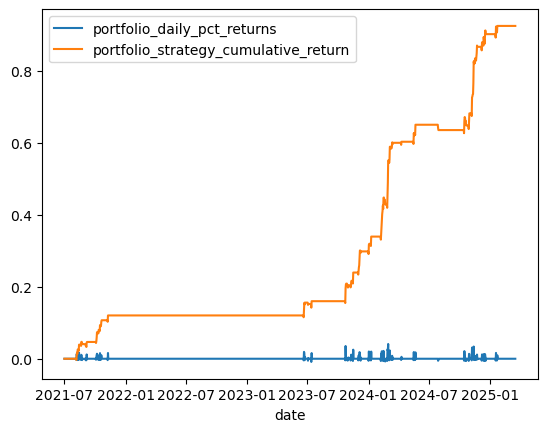

In [895]:
df_final_orig[['portfolio_daily_pct_returns','portfolio_strategy_cumulative_return']].plot()

In [909]:
df_final_orig.head()

BTC-USD  BTC-USD_50_6_250_mavg_crossover_20_donchian_signal  \
date                                                                       
2021-07-01  33516.11                                                  0    
2021-07-02  33805.02                                                  0    
2021-07-03  34682.16                                                  0    
2021-07-04  35284.05                                                  0    
2021-07-05  33697.78                                                  0    

            BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns  \
date                                                                       
2021-07-01                                               -0.0              
2021-07-02                                                0.0              
2021-07-03                                                0.0              
2021-07-04                                                0.0              
2021-07-05                                               -0.0              

            BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades  \
date                                                                      
2021-07-01                                                0.0             
2021-07-02                                                0.0             
2021-07-03                                                0.0             
2021-07-04                                                0.0             
2021-07-05                                                0.0             

            BTC-USD_actual_position_entry_price  \
date                                              
2021-07-01                                  0.0   
2021-07-02                                  0.0   
2021-07-03                                  0.0   
2021-07-04                                  0.0   
2021-07-05                                  0.0   

            BTC-USD_actual_position_exit_price  \
date                                             
2021-07-01                                 0.0   
2021-07-02                                 0.0   
2021-07-03                                 0.0   
2021-07-04                                 0.0   
2021-07-05                                 0.0   

            BTC-USD_actual_position_notional  BTC-USD_actual_size  \
date                                                                
2021-07-01                               0.0                  0.0   
2021-07-02                               0.0                  0.0   
2021-07-03                               0.0                  0.0   
2021-07-04                               0.0                  0.0   
2021-07-05                               0.0                  0.0   

            BTC-USD_annualized_volatility_20 BTC-USD_event  \
date                                                         
2021-07-01                          1.002070           NaN   
2021-07-02                          0.983669      No Event   
2021-07-03                          0.889133      No Event   
2021-07-04                          0.873244      No Event   
2021-07-05                          0.889056      No Event   

            BTC-USD_pct_returns  BTC-USD_position_volatility_adjusted_weight  \
date                                                                           
2021-07-01            -0.044036                                          0.0   
2021-07-02             0.008620                                          0.0   
2021-07-03             0.025947                                          0.0   
2021-07-04             0.017354                                          0.0   
2021-07-05            -0.044957                                          0.0   

            BTC-USD_short_sale_proceeds  BTC-USD_t_1_close  \
date                                                         
2021-07-01                          0.0           35060.00   
2021-07-02                          0.0       

In [937]:
df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                        end_date=end_date, save_to_file=False)

In [938]:
df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))

In [939]:
df.head()

BTC-USD_close  BTC-USD_open
date                                   
2021-06-01       36685.00      37276.23
2021-06-02       37577.91      36684.99
2021-06-03       39248.55      37581.83
2021-06-04       36856.52      39248.54
2021-06-05       35539.49      36856.53

In [83]:
importlib.reload(tf)
importlib.reload(size)

<module 'position_sizing' from '/Users/adheerchauhan/Documents/git/trend_following/position_sizing.py'>

In [121]:
start_date = '2021-06-01'
end_date = '2025-03-17'
ticker_list = ['BTC-USD']#,'ETH-USD','LTC-USD','SOL-USD']#,'XRP-USD']
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20
volatility_window = 20
annual_trading_days = 365
rolling_cov_window = 20
annualized_target_volatility = 0.30
use_specific_start_date = False
long_only=True
initial_capital = 15000
cash_buffer_percentage = 0.10
transaction_cost_est = 0.001
passive_trade_rate = 0.05

In [87]:
df_trend_orig_ticker = tf.get_trend_donchian_signal_for_portfolio(pd.to_datetime(start_date).date(), pd.to_datetime(end_date).date(), ticker_list, fast_mavg, slow_mavg, mavg_stepsize,
                                                                  rolling_donchian_window, long_only=False, price_or_returns_calc='price',
                                                                  use_coinbase_data=True)

In [89]:
df_trend_orig_ticker.head()

BTC-USD_close  BTC-USD_open  \
date                                      
2021-06-11       37338.44      36694.91   
2021-06-12       35557.33      37340.08   
2021-06-13       39015.24      35557.32   
2021-06-14       40539.47      39015.24   
2021-06-15       40162.37      40537.93   

            BTC-USD_50_6_250_mavg_crossover_20_donchian_signal  \
date                                                             
2021-06-11                                                  0    
2021-06-12                                                  0    
2021-06-13                                                  0    
2021-06-14                                                  0    
2021-06-15                                                  0    

            BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns  \
date                                                                       
2021-06-11                                                0.0              
2021-06-12                                               -0.0              
2021-06-13                                                0.0              
2021-06-14                                                0.0              
2021-06-15                                               -0.0              

            BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades  
date                                                                     
2021-06-11                                                NaN            
2021-06-12                                                0.0            
2021-06-13                                                0.0            
2021-06-14                                                0.0            
2021-06-15                                                0.0

In [91]:
df_trend_orig_ticker.groupby(['BTC-USD_50_6_250_mavg_crossover_20_donchian_signal']).size()

BTC-USD_50_6_250_mavg_crossover_20_donchian_signal
-1      34
 0    1246
 1      96
dtype: int64

In [93]:
df_filtered_trend_signal = df_trend_orig_ticker[df_trend_orig_ticker['BTC-USD_50_6_250_mavg_crossover_20_donchian_signal'] != 0]

In [95]:
df_filtered_trend_signal['cumulative_return'] = df_filtered_trend_signal['BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns'].cumsum()

In [97]:
df_filtered_trend_signal['cum_returns_quintile'] = pd.qcut(df_filtered_trend_signal['cumulative_return'], q=5, labels=['q1', 'q2', 'q3', 'q4', 'q5'])
df_filtered_trend_signal['daily_returns_quintile'] = pd.qcut(df_filtered_trend_signal['BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns'], q=5, labels=['q1', 'q2', 'q3', 'q4', 'q5'])

In [99]:
df_filtered_trend_signal

BTC-USD_close  BTC-USD_open  \
date                                      
2021-06-25       31594.63      34654.87   
2021-07-16       31388.06      31872.49   
2021-07-19       30842.03      31786.37   
2021-07-20       29796.16      30842.04   
2021-08-06       42869.58      40888.73   
2021-08-07       44637.34      42869.59   
2021-08-09       46285.48      43829.15   
2021-08-13       47833.64      44422.15   
2021-08-20       49342.40      46769.02   
2021-08-23       49506.50      49284.38   
2021-09-03       50025.00      49279.38   
2021-09-05       51789.17      49944.89   
2021-09-06       52698.81      51789.17   
2021-10-04       49245.54      48233.99   
2021-10-05       51493.99      49244.13   
2021-10-06       55339.48      51499.77   
2021-10-11       57487.44      54683.09   
2021-10-15       61695.39      57359.51   
2021-10-18       62042.41      61530.07   
2021-10-19       64303.14      62042.40   
2021-10-20       66026.54      64303.14   
2021-11-08       67554.84      63309.12   
2022-04-11       39535.87      42165.96   
2022-04-23       39465.87      39712.20   
2022-04-24       39464.56      39459.63   
2022-04-26       38113.82      40440.90   
2022-04-30       37644.10      38592.27   
2022-05-05       36537.22      39669.56   
2022-05-06       35999.10      36537.22   
2022-05-07       35458.00      35999.10   
2022-05-08       34027.91      35458.00   
2022-05-09       30078.27      34033.49   
2022-05-11       28972.34      31002.39   
2022-05-12       28941.95      28977.75   
2022-05-18       28672.94      30412.10   
2022-05-27       28598.31      29166.06   
2022-06-11       28388.63      29058.79   
2022-06-12       26555.20      28395.03   
2022-06-13       22460.97      26555.17   
2022-06-14       22120.25      22460.97   
2022-06-16       20372.00      22562.33   
2022-06-18       18948.89      20447.86   
2022-08-19       20834.94      23188.94   
2022-08-26       20240.72      21561.49   
2022-08-27       20036.69      20240.63   
2022-08-28       19554.03      20035.30   
2022-09-06       18790.91      19794.59   
2022-09-21       18462.64      18876.14   
2022-10-20       19042.48      19123.77   
2022-11-08       18550.25      20593.34   
2022-11-09       15891.96      18546.07   
2022-11-21       15760.14      16252.43   
2023-06-20       28320.43      26839.04   
2023-06-21       29995.08      28320.41   
2023-06-23       30707.61      29886.25   
2023-07-03       31161.80      30613.57   
2023-07-13       31471.83      30383.26   
2023-10-23       33087.58      30004.14   
2023-10-24       33922.52      33079.72   
2023-10-25       34506.35      33921.66   
2023-10-29       34534.48      34085.42   
2023-10-31       34656.40      34493.51   
2023-11-01       35440.10      34656.38   
2023-11-08       35639.13      35416.63   
2023-11-09       36706.59      35639.13   
2023-11-10       37324.83      36704.01   
2023-11-15       37885.35      35554.10   
2023-12-01       38703.54      37732.27   
2023-12-02       39478.95      38706.55   
2023-12-03       39984.81      39467.42   
2023-12-04       41987.24      39984.81   
2023-12-05       44084.39      41985.53   
2023-12-08       44192.87      43281.11   
2024-01-01       44220.78      42288.58   
2024-01-02       44972.80      44220.78   
2024-01-08       46995.10      43954.52   
2024-02-07       44343.61      43097.16   
2024-02-08       45305.20      44345.94   
2024-02-09       47160.41      45304.83   
2024-02-10       47767.06      47157.01   
2024-02-11       48316.30      47767.06   
2024-02-12       49941.81      48321.14   
2024-02-14       51858.59      49724.55   
2024-02-15       51934.29      51858.51   
2024-02-16       52162.64      51935.23   
2024-02-20       52277.52      51787.05   
2024-02-26       54533.48      51730.96   
2024-02-27       57077.07      54530.32   
2024-02-28       62518.90      57077.08   
2024-03-03       63154.49      62045.78   
2024-03-04       68360.14      63155.74   
2024-03-09   

In [101]:
df_filtered_trend_signal.groupby('daily_returns_quintile')['BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns'].mean()

daily_returns_quintile
q1    0.005477
q2    0.017150
q3    0.029802
q4    0.048694
q5    0.087065
Name: BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns, dtype: float64

In [103]:
df_trend_orig_ticker[f'BTC-USD_t_1_close'] = df_trend_orig_ticker[f'BTC-USD_close'].shift(1)
df_vol_test = tf.get_returns_volatility(df_trend_orig_ticker, vol_range_list=[20], close_px_col=f'BTC-USD_t_1_close')

In [105]:
df_vol_test.head()

BTC-USD_close  BTC-USD_open  \
date                                      
2021-06-11       37338.44      36694.91   
2021-06-12       35557.33      37340.08   
2021-06-13       39015.24      35557.32   
2021-06-14       40539.47      39015.24   
2021-06-15       40162.37      40537.93   

            BTC-USD_50_6_250_mavg_crossover_20_donchian_signal  \
date                                                             
2021-06-11                                                  0    
2021-06-12                                                  0    
2021-06-13                                                  0    
2021-06-14                                                  0    
2021-06-15                                                  0    

            BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns  \
date                                                                       
2021-06-11                                                0.0              
2021-06-12                                               -0.0              
2021-06-13                                                0.0              
2021-06-14                                                0.0              
2021-06-15                                               -0.0              

            BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades  \
date                                                                      
2021-06-11                                                NaN             
2021-06-12                                                0.0             
2021-06-13                                                0.0             
2021-06-14                                                0.0             
2021-06-15                                                0.0             

            BTC-USD_t_1_close  BTC-USD_t_1_close_pct_returns  \
date                                                           
2021-06-11                NaN                            NaN   
2021-06-12           37338.44                            NaN   
2021-06-13           35557.33                      -0.047702   
2021-06-14           39015.24                       0.097249   
2021-06-15           40539.47                       0.039068   

            BTC-USD_t_1_close_volatility_20  
date                                         
2021-06-11                              NaN  
2021-06-12                              NaN  
2021-06-13                              NaN  
2021-06-14                              NaN  
2021-06-15                              NaN

In [107]:
df_vol_adj_trend = size.get_volatility_adjusted_trend_signal(df_trend_orig_ticker, ticker_list, volatility_window, fast_mavg, mavg_stepsize,
                                                             slow_mavg, rolling_donchian_window, annual_trading_days)

In [109]:
df_vol_adj_trend.head(200)

BTC-USD_close  BTC-USD_open  BTC-USD_t_1_close  \
date                                                         
2021-06-11       37338.44      36694.91                NaN   
2021-06-12       35557.33      37340.08           37338.44   
2021-06-13       39015.24      35557.32           35557.33   
2021-06-14       40539.47      39015.24           39015.24   
2021-06-15       40162.37      40537.93           40539.47   
2021-06-16       38351.00      40158.06           40162.37   
2021-06-17       38095.17      38351.00           38351.00   
2021-06-18       35841.81      38103.94           38095.17   
2021-06-19       35484.79      35840.96           35841.81   
2021-06-20       35585.78      35484.80           35484.79   
2021-06-21       31609.82      35585.79           35585.78   
2021-06-22       32538.37      31609.82           31609.82   
2021-06-23       33688.35      32538.90           32538.37   
2021-06-24       34654.58      33688.51           33688.35   
2021-06-25       31594.63      34654.87           34654.58   
2021-06-26       32275.19      31594.62           31594.63   
2021-06-27       34709.23      32267.59           32275.19   
2021-06-28       34493.22      34708.53           34709.23   
2021-06-29       35904.28      34493.22           34493.22   
2021-06-30       35060.00      35906.17           35904.28   
2021-07-01       33516.11      35060.00           35060.00   
2021-07-02       33805.02      33510.93           33516.11   
2021-07-03       34682.16      33805.01           33805.02   
2021-07-04       35284.05      34685.03           34682.16   
2021-07-05       33697.78      35284.06           35284.05   
2021-07-06       34225.73      33697.78           33697.78   
2021-07-07       33878.56      34225.72           34225.73   
2021-07-08       32875.95      33879.50           33878.56   
2021-07-09       33824.26      32875.95           32875.95   
2021-07-10       33515.35      33824.25           33824.26   
2021-07-11       34259.23      33515.35           33515.35   
2021-07-12       33091.10      34259.22           34259.23   
2021-07-13       32734.14      33077.43           33091.10   
2021-07-14       32816.39      32734.14           32734.14   
2021-07-15       31868.68      32815.75           32816.39   
2021-07-16       31388.06      31872.49           31868.68   
2021-07-17       31533.91      31389.57           31388.06   
2021-07-18       31788.25      31533.90           31533.91   
2021-07-19       30842.03      31786.37           31788.25   
2021-07-20       29796.16      30842.04           30842.03   
2021-07-21       32135.19      29796.15           29796.16   
2021-07-22       32287.74      32152.68           32135.19   
2021-07-23       33647.26      32287.75           32287.74   
2021-07-24       34283.01      33647.27           33647.26   
2021-07-25       35428.26      34291.67           34283.01   
2021-07-26       37262.77      35428.25           35428.26   
2021-07-27       39470.48      37262.76           37262.77   
2021-07-28       40035.10      39475.99           39470.48   
2021-07-29       40039.44      40035.10           40035.10   
2021-07-30       42237.95      40039.44           40039.44   
2021-07-31       41495.01      42233.66           42237.95   
2021-08-01       39865.41      41499.00           41495.01   
2021-08-02       39149.59      39859.18           39865.41   
2021-08-03       38191.44      39149.59           39149.59   
2021-08-04       39722.41      38189.40           38191.44   
2021-08-05       40888.74      39718.90           39722.41   
2021-08-06       42869.58      40888.73           40888.74   
2021-08-07       44637.34      42869.59           42869.58   
2021-08-08       43829.14      44628.11           44637.34   
2021-08-09       46285.48      43829.15           43829.14   
2021-08-10       45595.66      46280.00           46285.48   
2021-08-11       45553.49      45601.82           45595.66   
2021-08-12       44422.14      45553.10     

In [111]:
df_vol_adj_trend.groupby(['BTC-USD_position_volatility_adjusted_weight']).size()

BTC-USD_position_volatility_adjusted_weight
-1.0      33
 0.0    1247
 1.0      96
dtype: int64

In [115]:
df = df_vol_adj_trend.copy()

In [125]:
df_daily_pos = size.get_target_volatility_daily_portfolio_positions(df=df_vol_adj_trend, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize,
                                                               rolling_donchian_window=rolling_donchian_window, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window,
                                                               cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
                                                               transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, annual_trading_days=annual_trading_days,
                                                               use_specific_start_date=False, signal_start_date=None)

In [127]:
df_daily_pos.head(20)

BTC-USD_50_6_250_mavg_crossover_20_donchian_signal  \
date                                                             
2021-07-02                                                  0    
2021-07-03                                                  0    
2021-07-04                                                  0    
2021-07-05                                                  0    
2021-07-06                                                  0    
2021-07-07                                                  0    
2021-07-08                                                  0    
2021-07-09                                                  0    
2021-07-10                                                  0    
2021-07-11                                                  0    
2021-07-12                                                  0    
2021-07-13                                                  0    
2021-07-14                                                  0    
2021-07-15                                                  0    
2021-07-16                                                 -1    
2021-07-17                                                  0    
2021-07-18                                                  0    
2021-07-19                                                 -1    
2021-07-20                                                 -1    
2021-07-21                                                  0    

            BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns  \
date                                                                       
2021-07-02                                           0.000000              
2021-07-03                                           0.000000              
2021-07-04                                           0.000000              
2021-07-05                                          -0.000000              
2021-07-06                                           0.000000              
2021-07-07                                          -0.000000              
2021-07-08                                          -0.000000              
2021-07-09                                           0.000000              
2021-07-10                                          -0.000000              
2021-07-11                                           0.000000              
2021-07-12                                          -0.000000              
2021-07-13                                          -0.000000              
2021-07-14                                           0.000000              
2021-07-15                                          -0.000000              
2021-07-16                                           0.015081              
2021-07-17                                           0.000000              
2021-07-18                                           0.000000              
2021-07-19                                           0.029766              
2021-07-20                                           0.033911              
2021-07-21                                           0.000000              

            BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades  \
date                                                                      
2021-07-02                                                0.0             
2021-07-03                                                0.0             
2021-07-04                                                0.0             
2021-07-05                                                0.0             
2021-07-06                                                0.0             
2021-07-07                                                0.0             
2021-07-08                                                0.0             
2021-07-09                                                0.0             
2021-07-10                                                0.0             
2021-07-11                                                0.0

In [135]:
## TODO: FIX THIS
df_daily_pos[df_daily_pos['BTC-USD_event'].isnull()].tail()

BTC-USD_50_6_250_mavg_crossover_20_donchian_signal  \
date                                                             
2021-07-02                                                  0    
2022-10-21                                                  0    
2023-07-14                                                  0    
2023-11-16                                                  0    

            BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns  \
date                                                                       
2021-07-02                                                0.0              
2022-10-21                                                0.0              
2023-07-14                                               -0.0              
2023-11-16                                               -0.0              

            BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades  \
date                                                                      
2021-07-02                                                0.0             
2022-10-21                                                1.0             
2023-07-14                                               -1.0             
2023-11-16                                               -1.0             

            BTC-USD_actual_position_entry_price  \
date                                              
2021-07-02                                  0.0   
2022-10-21                                  0.0   
2023-07-14                                  0.0   
2023-11-16                                  0.0   

            BTC-USD_actual_position_exit_price  \
date                                             
2021-07-02                                 0.0   
2022-10-21                                 0.0   
2023-07-14                                 0.0   
2023-11-16                                 0.0   

            BTC-USD_actual_position_notional  BTC-USD_actual_size  \
date                                                                
2021-07-02                               0.0                  0.0   
2022-10-21                               0.0                  0.0   
2023-07-14                               0.0                  0.0   
2023-11-16                               0.0                  0.0   

            BTC-USD_annualized_volatility_20  BTC-USD_close BTC-USD_event  \
date                                                                        
2021-07-02                          1.002070       33805.02           NaN   
2022-10-21                          0.285699       19166.45           NaN   
2023-07-14                          0.258604       30330.52           NaN   
2023-11-16                          0.369575       36161.15           NaN   

            BTC-USD_open  BTC-USD_position_volatility_adjusted_weight  \
date                                                                    
2021-07-02      33510.93                                          0.0   
2022-10-21      19043.66                                          0.0   
2023-07-14      31471.83                                          0.0   
2023-11-16      37885.35                                          0.0   

            BTC-USD_short_sale_proceeds  BTC-USD_t_1_close  \
date                                                         
2021-07-02                          0.0           33516.11   
2022-10-21                          0.0           19042.48   
2023-07-14                          0.0           31471.83   
2023-11-16                          0.0           37885.35   

            BTC-USD_t_1_close_pct_returns  BTC-USD_target_notional  \
date                                                                 
2021-07-02                      -0.044036                      0.0   
2022-10-21                      -0.004272                      0.0   
2023-07-14                       0.035877                      0.0   
2023-11-16                       0.065569                  

In [131]:
df_daily_pos.groupby(['BTC-USD_event']).size()

BTC-USD_event
Closing Long Position       49
Closing Short Position      19
New Long Position           49
New Short Position          19
No Event                  1157
Open Long Position          45
Open Short Position         13
dtype: int64

In [59]:
## Calculate the covariance matrix for tickers in the portfolio
returns_cols = [f'{ticker}_t_1_close_pct_returns' for ticker in ticker_list]
cov_matrix = df[returns_cols].rolling(rolling_cov_window).cov(pairwise=True).dropna()

## Delete rows prior to the first available date of the covariance matrix
cov_matrix_start_date = cov_matrix.index[0][0]
df = df[df.index >= cov_matrix_start_date]

## Derive the Daily Target Portfolio Volatility
daily_target_volatility = annualized_target_volatility / np.sqrt(annual_trading_days)

In [61]:
df.head()

BTC-USD_close  BTC-USD_open  BTC-USD_t_1_close  \
date                                                         
2021-08-09       46285.48      43829.15           43829.14   
2021-08-10       45595.66      46280.00           46285.48   
2021-08-11       45553.49      45601.82           45595.66   
2021-08-12       44422.14      45553.10           45553.49   
2021-08-13       47833.64      44422.15           44422.14   

            BTC-USD_t_1_close_pct_returns  \
date                                        
2021-08-09                      -0.018106   
2021-08-10                       0.056044   
2021-08-11                      -0.014904   
2021-08-12                      -0.000925   
2021-08-13                      -0.024836   

            BTC-USD_50_6_250_mavg_crossover_20_donchian_signal  \
date                                                             
2021-08-09                                                  1    
2021-08-10                                                  0    
2021-08-11                                                  0    
2021-08-12                                                  0    
2021-08-13                                                  1    

            BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns  \
date                                                                       
2021-08-09                                           0.056044              
2021-08-10                                          -0.000000              
2021-08-11                                          -0.000000              
2021-08-12                                          -0.000000              
2021-08-13                                           0.076797              

            BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades  \
date                                                                      
2021-08-09                                                1.0             
2021-08-10                                               -1.0             
2021-08-11                                                0.0             
2021-08-12                                                0.0             
2021-08-13                                                1.0             

            BTC-USD_annualized_volatility_20  \
date                                           
2021-08-09                          0.663521   
2021-08-10                          0.638372   
2021-08-11                          0.605644   
2021-08-12                          0.608528   
2021-08-13                          0.624231   

            BTC-USD_vol_adjusted_trend_signal  \
date                                            
2021-08-09                           1.507110   
2021-08-10                           0.000000   
2021-08-11                           0.000000   
2021-08-12                           0.000000   
2021-08-13                           1.601972   

            BTC-USD_position_volatility_adjusted_weight  
date                                                     
2021-08-09                                          1.0  
2021-08-10                                          0.0  
2021-08-11                                          0.0  
2021-08-12                                          0.0  
2021-08-13                                          1.0

In [63]:
cov_matrix

BTC-USD_t_1_close_pct_returns
date                                                                   
2021-08-09 BTC-USD_t_1_close_pct_returns                       0.001206
2021-08-10 BTC-USD_t_1_close_pct_returns                       0.001116
2021-08-11 BTC-USD_t_1_close_pct_returns                       0.001005
2021-08-12 BTC-USD_t_1_close_pct_returns                       0.001015
2021-08-13 BTC-USD_t_1_close_pct_returns                       0.001068
2021-08-14 BTC-USD_t_1_close_pct_returns                       0.001262
2021-08-15 BTC-USD_t_1_close_pct_returns                       0.001298
2021-08-16 BTC-USD_t_1_close_pct_returns                       0.001234
2021-08-17 BTC-USD_t_1_close_pct_returns                       0.001168
2021-08-18 BTC-USD_t_1_close_pct_returns                       0.001226
2021-08-19 BTC-USD_t_1_close_pct_returns                       0.001225
2021-08-20 BTC-USD_t_1_close_pct_returns                       0.001184
2021-08-21 BTC-USD_t_1_close_pct_returns                       0.001270
2021-08-22 BTC-USD_t_1_close_pct_returns                       0.001162
2021-08-23 BTC-USD_t_1_close_pct_returns                       0.001117
2021-08-24 BTC-USD_t_1_close_pct_returns                       0.001048
2021-08-25 BTC-USD_t_1_close_pct_returns                       0.001129
2021-08-26 BTC-USD_t_1_close_pct_returns                       0.001125
2021-08-27 BTC-USD_t_1_close_pct_returns                       0.001172
2021-08-28 BTC-USD_t_1_close_pct_returns                       0.001198
2021-08-29 BTC-USD_t_1_close_pct_returns                       0.001172
2021-08-30 BTC-USD_t_1_close_pct_returns                       0.001035
2021-08-31 BTC-USD_t_1_close_pct_returns                       0.001102
2021-09-01 BTC-USD_t_1_close_pct_returns                       0.001102
2021-09-02 BTC-USD_t_1_close_pct_returns                       0.001116
2021-09-03 BTC-USD_t_1_close_pct_returns                       0.000835
2021-09-04 BTC-USD_t_1_close_pct_returns                       0.000827
2021-09-05 BTC-USD_t_1_close_pct_returns                       0.000827
2021-09-06 BTC-USD_t_1_close_pct_returns                       0.000838
2021-09-07 BTC-USD_t_1_close_pct_returns                       0.000781
2021-09-08 BTC-USD_t_1_close_pct_returns                       0.001488
2021-09-09 BTC-USD_t_1_close_pct_returns                       0.001403
2021-09-10 BTC-USD_t_1_close_pct_returns                       0.001240
2021-09-11 BTC-USD_t_1_close_pct_returns                       0.001286
2021-09-12 BTC-USD_t_1_close_pct_returns                       0.001284
2021-09-13 BTC-USD_t_1_close_pct_returns                       0.001307
2021-09-14 BTC-USD_t_1_close_pct_returns                       0.001268
2021-09-15 BTC-USD_t_1_close_pct_returns                       0.001357
2021-09-16 BTC-USD_t_1_close_pct_returns                       0.001279
2021-09-17 BTC-USD_t_1_close_pct_returns                       0.001167
2021-09-18 BTC-USD_t_1_close_pct_returns                       0.001171
2021-09-19 BTC-USD_t_1_close_pct_returns                       0.001196
2021-09-20 BTC-USD_t_1_close_pct_returns                       0.001148
2021-09-21 BTC-USD_t_1_close_pct_returns                       0.001557
2021-09-22 BTC-USD_t_1_close_pct_returns                       0.001579
2021-09-23 BTC-USD_t_1_close_pct_returns                       0.001877
2021-09-24 BTC-USD_t_1_close_pct_returns                       0.001921
2021-09-25 BTC-USD_t_1_close_pct_returns                       0.002005
2021-09-26 BTC-USD_t_1_close_pct_returns                       0.001901
2021-09-27 BTC-USD_t_1_close_pct_returns                       0.001886
2021-09-28 BTC-USD_t_1_close_pct_returns                       0.001338
2021-09-29 BTC-USD_t_1_close_pct_returns                       0.001355
2021-09-30 BTC-USD_t_1_close_pct_returns                       0.001363
2021-10-01 BTC-USD_t_1_close_pct_returns                       0.001491
2021-10-02

In [79]:
## Reorder dataframe columns
col_list = []
for ticker in ticker_list:
    df[f'{ticker}_actual_size'] = 0.0
    df[f'{ticker}_actual_position_notional'] = 0.0
    df[f'{ticker}_short_sale_proceeds'] = 0.0
    df[f'{ticker}_actual_position_entry_price'] = 0.0
    df[f'{ticker}_actual_position_exit_price'] = 0.0
    df[f'{ticker}_target_vol_normalized_weight'] = 0.0
    df[f'{ticker}_target_notional'] = 0.0
    df[f'{ticker}_target_size'] = 0.0
    df[f'{ticker}_event'] = np.nan
ord_cols = size.reorder_columns_by_ticker(df.columns, ticker_list)
df = df[ord_cols]

## Portfolio Level Cash and Positions are all set to 0
df['daily_portfolio_volatility'] = 0.0
df['available_cash'] = 0.0
df['count_of_positions'] = 0.0
df['total_actual_position_notional'] = 0.0
df['total_target_notional'] = 0.0
df['total_portfolio_value'] = 0.0
df['total_portfolio_value_upper_limit'] = 0.0
df['target_vol_scaling_factor'] = 1.0
df['target_notional_scaling_factor'] = 1.0

## Cash and the Total Portfolio Value on Day 1 is the initial capital for the strategy
if use_specific_start_date:
    start_index_position = df.index.get_loc(signal_start_date)
else:
    start_index_position = 0
df['available_cash'][start_index_position] = initial_capital
df['total_portfolio_value'][start_index_position] = initial_capital

In [81]:
df.head(20)

BTC-USD_50_6_250_mavg_crossover_20_donchian_signal  \
date                                                             
2021-08-09                                                  1    
2021-08-10                                                  0    
2021-08-11                                                  0    
2021-08-12                                                  0    
2021-08-13                                                  1    
2021-08-14                                                  0    
2021-08-15                                                  0    
2021-08-16                                                  0    
2021-08-17                                                  0    
2021-08-18                                                  0    
2021-08-19                                                  0    
2021-08-20                                                  1    
2021-08-21                                                  0    
2021-08-22                                                  0    
2021-08-23                                                  1    
2021-08-24                                                  0    
2021-08-25                                                  0    
2021-08-26                                                  0    
2021-08-27                                                  0    
2021-08-28                                                  0    

            BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns  \
date                                                                       
2021-08-09                                           0.056044              
2021-08-10                                          -0.000000              
2021-08-11                                          -0.000000              
2021-08-12                                          -0.000000              
2021-08-13                                           0.076797              
2021-08-14                                          -0.000000              
2021-08-15                                          -0.000000              
2021-08-16                                          -0.000000              
2021-08-17                                          -0.000000              
2021-08-18                                           0.000000              
2021-08-19                                           0.000000              
2021-08-20                                           0.055094              
2021-08-21                                          -0.000000              
2021-08-22                                           0.000000              
2021-08-23                                           0.004502              
2021-08-24                                          -0.000000              
2021-08-25                                           0.000000              
2021-08-26                                          -0.000000              
2021-08-27                                           0.000000              
2021-08-28                                          -0.000000              

            BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades  \
date                                                                      
2021-08-09                                                1.0             
2021-08-10                                               -1.0             
2021-08-11                                                0.0             
2021-08-12                                                0.0             
2021-08-13                                                1.0             
2021-08-14                                               -1.0             
2021-08-15                                                0.0             
2021-08-16                                                0.0             
2021-08-17                                                0.0             
2021-08-18                                                0.0

In [ ]:
## Identify Daily Positions starting from day 2
for date in df.index[start_index_position + 1:]:
    previous_date = df.index[df.index.get_loc(date) - 1]

    ## Start the day with the available cash from yesterday
    df['available_cash'].loc[date] = df['available_cash'].loc[previous_date]
    total_portfolio_value_upper_limit = (df['total_portfolio_value'].loc[previous_date] *
                                         (1 - cash_buffer_percentage))
    df['total_portfolio_value_upper_limit'].loc[date] = total_portfolio_value_upper_limit

    ## Calculate the target notional by ticker
    df = get_target_volatility_position_sizing(df, cov_matrix, date, ticker_list, daily_target_volatility,
                                               total_portfolio_value_upper_limit)

    ## Get the daily positions
    df = get_daily_positions_and_portfolio_cash(df, date, ticker_list, fast_mavg, mavg_stepsize, slow_mavg,
                                                rolling_donchian_window, transaction_cost_est, passive_trade_rate)

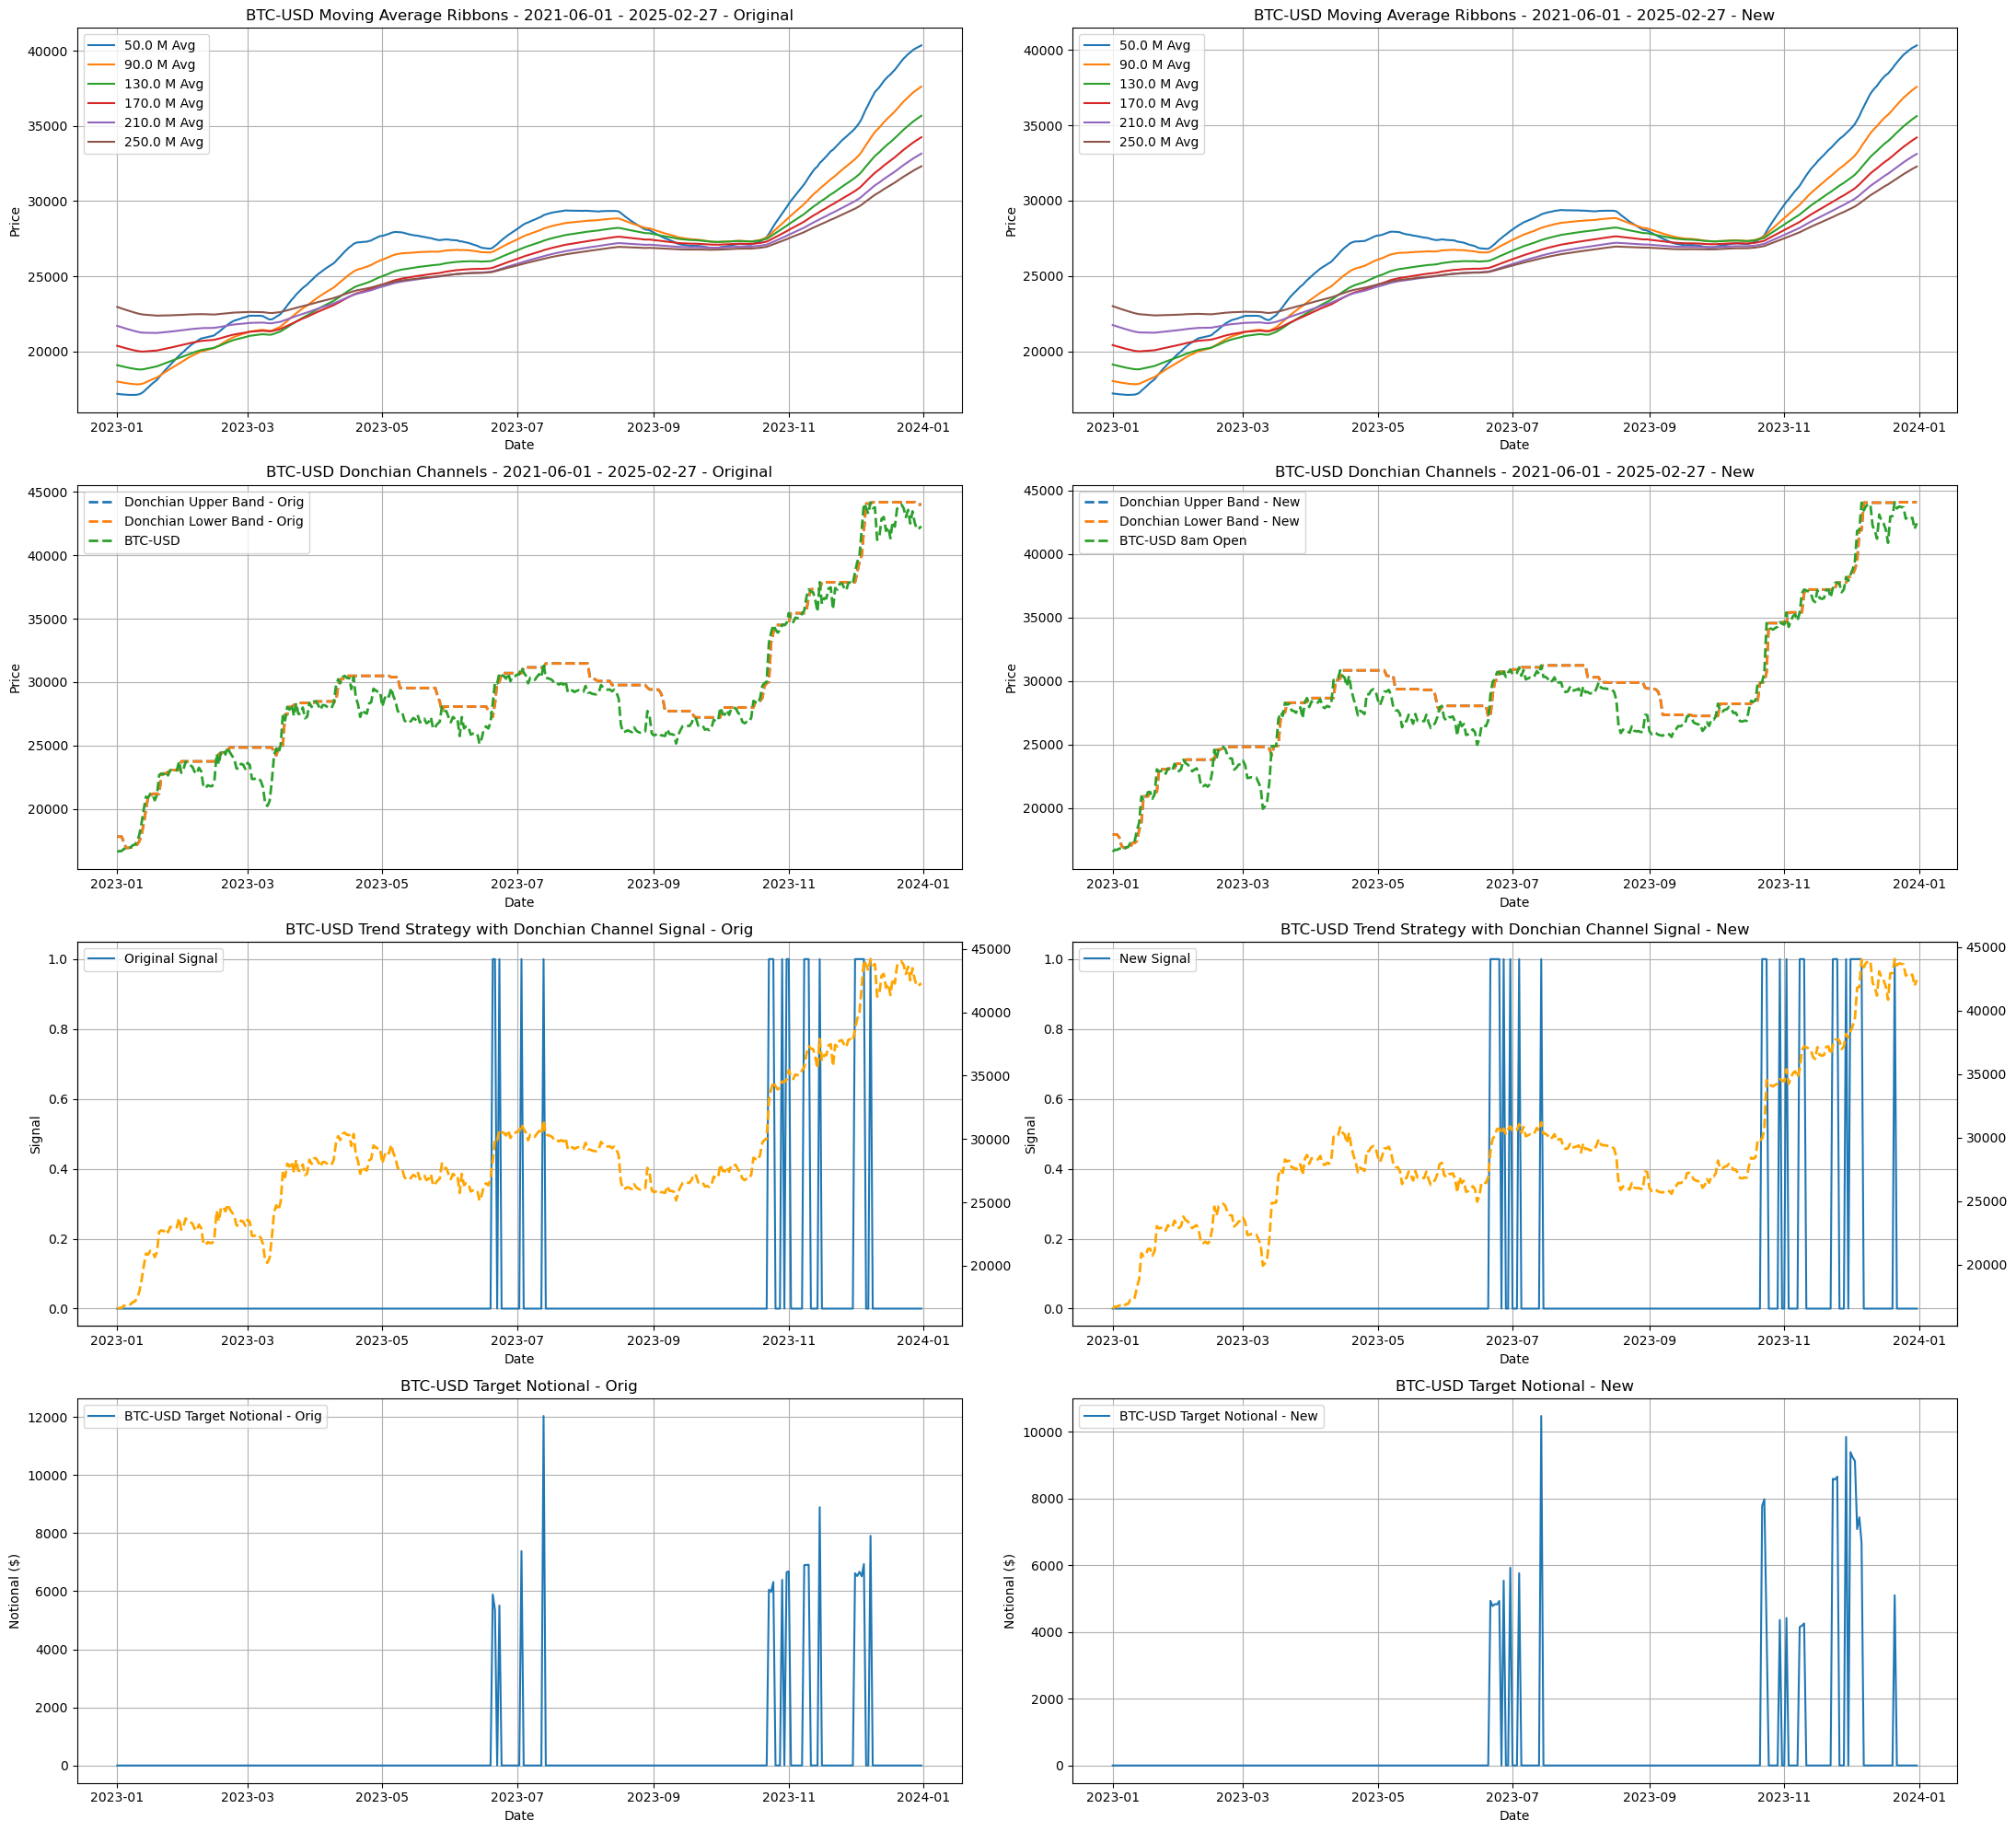

In [180]:
start_date = pd.to_datetime(start_date).date().strftime('%Y-%m-%d')
end_date = pd.to_datetime(end_date).date().strftime('%Y-%m-%d')
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20
ticker = 'BTC-USD'
price_or_returns_calc = 'price'
fig = plt.figure(figsize=(22,20))
layout = (4,2)
mavg_ax_orig = plt.subplot2grid(layout, (0,0))
mavg_ax_new = plt.subplot2grid(layout, (0,1))
donchian_ax_orig = plt.subplot2grid(layout, (1,0))
donchian_ax_new = plt.subplot2grid(layout, (1,1))
trend_signal_ax_orig = plt.subplot2grid(layout, (2,0))
trend_signal_ax_orig_2 = trend_signal_ax_orig.twinx()
trend_signal_ax_new = plt.subplot2grid(layout, (2,1))
trend_signal_ax_new_2 = trend_signal_ax_new.twinx()
target_notional_ax_orig = plt.subplot2grid(layout, (3,0))
target_notional_ax_new = plt.subplot2grid(layout, (3,1))


mavg_cols = ['BTC-USD_50_mavg', 'BTC-USD_90_mavg', 'BTC-USD_130_mavg', 'BTC-USD_170_mavg',
             'BTC-USD_210_mavg', 'BTC-USD_250_mavg']
orig_date_cond = (df_trend_orig.index >= pd.Timestamp('2023-01-01').date()) & (df_trend_orig.index <= pd.Timestamp('2023-12-31').date())
new_date_cond = (df_trend.index >= pd.Timestamp('2023-01-01').date()) & (df_trend.index <= pd.Timestamp('2023-12-31').date())
for mavg in np.linspace(fast_mavg, slow_mavg, mavg_stepsize):
    _ = mavg_ax_orig.plot(df_trend_orig[orig_date_cond].index, df_trend_orig[orig_date_cond][f'{ticker}_{int(mavg)}_mavg'], label=f'{mavg} M Avg')
    _ = mavg_ax_new.plot(df_trend[new_date_cond].index, df_trend[new_date_cond][f'{ticker}_{int(mavg)}_mavg'], label=f'{mavg} M Avg')

_ = donchian_ax_orig.plot(df_trend_orig[orig_date_cond].index,
                  df_trend_orig[orig_date_cond][f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}'], label='Donchian Upper Band - Orig', linestyle='--', linewidth=2)
_ = donchian_ax_orig.plot(df_trend_orig[orig_date_cond].index,
                  df_trend_orig[orig_date_cond][f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}'], label='Donchian Lower Band - Orig', linestyle='--', linewidth=2)
_ = donchian_ax_orig.plot(df_trend_orig[orig_date_cond].index,
                  df_trend_orig[orig_date_cond][f'{ticker}'], label=f'{ticker}', linestyle='--', linewidth=2)
_ = donchian_ax_new.plot(df_trend[new_date_cond].index,
                  df_trend[new_date_cond][f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}'], label='Donchian Upper Band - New', linestyle='--', linewidth=2)
_ = donchian_ax_new.plot(df_trend[new_date_cond].index,
                  df_trend[new_date_cond][f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}'], label='Donchian Lower Band - New', linestyle='--', linewidth=2)
_ = donchian_ax_new.plot(df_trend[new_date_cond].index,
                  df_trend[new_date_cond][f'{ticker}_8am_open_price'], label=f'{ticker} 8am Open', linestyle='--', linewidth=2)

_ = trend_signal_ax_orig.plot(df_trend_orig[orig_date_cond].index,
                              df_trend_orig[orig_date_cond][f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'], label=f'Original Signal')
_ = trend_signal_ax_orig_2.plot(df_trend_orig[orig_date_cond].index,
                              df_trend_orig[orig_date_cond][f'{ticker}'], label=f'{ticker}', linestyle='--', linewidth=2, color='orange')
_ = trend_signal_ax_new.plot(df_trend[new_date_cond].index,
                             df_trend[new_date_cond][f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'], label=f'New Signal')
_ = trend_signal_ax_new_2.plot(df_trend[new_date_cond].index,
                             df_trend[new_date_cond][f'{ticker}_8am_open_price'], label=f'{ticker} 8am Open', linestyle='--', linewidth=2, color='orange')

orig_date_cond = (df_final_orig.index >= pd.Timestamp('2023-01-01').date()) & (df_final_orig.index <= pd.Timestamp('2023-12-31').date())
new_date_cond = (df_final.index >= pd.Timestamp('2023-01-01').date()) & (df_final.index <= pd.Timestamp('2023-12-31').date())
_ = target_notional_ax_orig.plot(df_final_orig[orig_date_cond].index, df_final_orig[orig_date_cond][f'{ticker}_target_notional'], label=f'{ticker} Target Notional - Orig')
_ = target_notional_ax_new.plot(df_final[new_date_cond].index, df_final[new_date_cond][f'{ticker}_target_notional'], label=f'{ticker} Target Notional - New')

_ = mavg_ax_orig.set_title(f'{ticker} Moving Average Ribbons - {start_date} - {end_date} - Original')
_ = mavg_ax_orig.set_ylabel('Price')
_ = mavg_ax_orig.set_xlabel('Date')
_ = mavg_ax_orig.legend(loc='upper left')
_ = mavg_ax_orig.grid()

_ = mavg_ax_new.set_title(f'{ticker} Moving Average Ribbons - {start_date} - {end_date} - New')
_ = mavg_ax_new.set_ylabel('Price')
_ = mavg_ax_new.set_xlabel('Date')
_ = mavg_ax_new.legend(loc='upper left')
_ = mavg_ax_new.grid()

_ = donchian_ax_orig.set_title(f'{ticker} Donchian Channels - {start_date} - {end_date} - Original')
_ = donchian_ax_orig.set_ylabel('Price')
_ = donchian_ax_orig.set_xlabel('Date')
_ = donchian_ax_orig.legend(loc='upper left')
_ = donchian_ax_orig.grid()

_ = donchian_ax_new.set_title(f'{ticker} Donchian Channels - {start_date} - {end_date} - New')
_ = donchian_ax_new.set_ylabel('Price')
_ = donchian_ax_new.set_xlabel('Date')
_ = donchian_ax_new.legend(loc='upper left')
_ = donchian_ax_new.grid()

_ = trend_signal_ax_orig.set_title(f'{ticker} Trend Strategy with Donchian Channel Signal - Orig')
_ = trend_signal_ax_orig.set_ylabel('Signal')
_ = trend_signal_ax_orig.set_xlabel('Date')
_ = trend_signal_ax_orig.legend(loc='upper left')
_ = trend_signal_ax_orig.grid()

_ = trend_signal_ax_new.set_title(f'{ticker} Trend Strategy with Donchian Channel Signal - New')
_ = trend_signal_ax_new.set_ylabel('Signal')
_ = trend_signal_ax_new.set_xlabel('Date')
_ = trend_signal_ax_new.legend(loc='upper left')
_ = trend_signal_ax_new.grid()

_ = target_notional_ax_orig.set_title(f'{ticker} Target Notional - Orig')
_ = target_notional_ax_orig.set_ylabel('Notional ($)')
_ = target_notional_ax_orig.set_xlabel('Date')
_ = target_notional_ax_orig.legend(loc='upper left')
_ = target_notional_ax_orig.grid()

_ = target_notional_ax_new.set_title(f'{ticker} Target Notional - New')
_ = target_notional_ax_new.set_ylabel('Notional ($)')
_ = target_notional_ax_new.set_xlabel('Date')
_ = target_notional_ax_new.legend(loc='upper left')
_ = target_notional_ax_new.grid()


# if price_or_returns_calc == 'price':
#     _ = trend_donchian_ax.plot(df.index, df[f'{ticker}'], label='Price')
# elif price_or_returns_calc == 'returns':
#     _ = trend_donchian_ax.plot(df.index, df[f'{ticker}_pct_returns'], label='Returns')
# _ = trend_donchian_ax.plot(df.index,
#                   df[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}'], label='Donchian Upper Band', linestyle='--', linewidth=3)
# _ = trend_donchian_ax.plot(df.index,
#                   df[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}'], label='Donchian Lower Band', linestyle='--', linewidth=3)

# _ = trend_donchian_ax.set_title(f'{ticker} Donchian Channels')
# _ = trend_donchian_ax.set_ylabel('Price')
# _ = trend_donchian_ax.set_xlabel('Date')
# _ = trend_donchian_ax.legend(loc='upper left')
# _ = trend_donchian_ax.grid()

# _ = trend_signal_ax.plot(df.index,
#                          df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'], label='Signal')
# _ = trend_signal_ax2.plot(df.index, df[f'{ticker}'], label='Price', alpha=0.8, color='orange', linestyle='--')
# _ = trend_signal_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Signal')
# _ = trend_signal_ax.set_ylabel('Signal')
# _ = trend_signal_ax.set_xlabel('Date')
# _ = trend_signal_ax.legend(loc='upper left')
# _ = trend_signal_ax.grid()

# _ = trend_rolling_sharpe_ax.plot(df.index,
#                                  df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_rolling_sharpe_{rolling_sharpe_window}'],
#                                  label='Sharpe Ratio', color='orange')
# _ = trend_rolling_sharpe_ax.set_title(f'{ticker} Rolling Sharpe Ratio')
# _ = trend_rolling_sharpe_ax.set_ylabel('Sharpe Ratio')
# _ = trend_rolling_sharpe_ax.set_xlabel('Date')
# _ = trend_rolling_sharpe_ax.legend(loc='upper left')
# _ = trend_rolling_sharpe_ax.grid()

# _ = trend_return_ax.plot(df.index,
#                          df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'],
#                          label='Return')
# _ = trend_return_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Return')
# _ = trend_return_ax.set_ylabel('Return')
# _ = trend_return_ax.set_xlabel('Date')
# _ = trend_return_ax.legend(loc='upper left')
# _ = trend_return_ax.grid()

# # _ = trend_cum_return_ax.plot(df_trend_mavg_donchian.index, df_trend_mavg_donchian[f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_cum'], label='Cum. Return')
# _ = trend_cum_return_ax.plot(df.index, df['strategy_cumulative_return'], label='Cum. Return')
# _ = trend_cum_return_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Cumulative Return')
# _ = trend_cum_return_ax.set_ylabel('Cum. Return')
# _ = trend_cum_return_ax.set_xlabel('Date')
# _ = trend_cum_return_ax.legend(loc='upper left')
# _ = trend_cum_return_ax.grid()


plt.tight_layout()

In [64]:
start_quarter

datetime.date(2025, 1, 1)

In [152]:
start_date

'2025-01-01'

In [154]:
end_date

'2025-03-31'

In [158]:
ticker

'BTC-USD'

In [165]:
df_prices = get_coinbase_price_at_timestamp(client, ticker, start_date, end_date)

In [166]:
df_prices

8am_open_price  8am_close_price
date                                       
2025-01-01        93614.94         93583.67
2025-01-02        96754.55         96747.24
2025-01-03        96585.53         96591.16
2025-01-04        97853.76         97853.21
2025-01-05        97737.02         97737.01
2025-01-06        99131.85         99178.93
2025-01-07       100752.30        100727.87
2025-01-08        94852.71         94981.05
2025-01-09        93371.21         93354.87
2025-01-10        95018.32         94997.79
2025-01-11        94507.24         94544.88
2025-01-12        94286.72         94298.56
2025-01-13        90644.29         90509.77
2025-01-14        95945.54         95999.32
2025-01-15        96889.93         96891.48
2025-01-16        99368.40         99284.16
2025-01-17       102746.61        102879.91
2025-01-18       103392.73        103405.45
2025-01-19       104767.03        104823.45
2025-01-20       106798.18        106696.79
2025-01-21       104426.42        104437.18
2025-01-22       105261.37        105272.78
2025-01-23       101590.99        101591.64
2025-01-24       105546.94        105522.62
2025-01-25       104741.91        104800.80
2025-01-26       104889.39        104883.21
2025-01-27       100590.46        100438.24
2025-01-28       102597.69        102621.84
2025-01-29       102197.32        102167.65
2025-01-30       105012.04        104988.12
2025-01-31       104701.56        104743.96
2025-02-01       102258.15        102220.83
2025-02-02        98141.85         98173.98
2025-02-03        94850.00         94906.90
2025-02-04        99460.67         99355.47
2025-02-05        98103.77         98058.32
2025-02-06        98374.78         98323.30
2025-02-07        97998.69         97996.56
2025-02-08        96060.27         96086.28
2025-02-09        96563.48         96518.18
2025-02-10        97390.38         97460.09
2025-02-11        97792.18         97762.09
2025-02-12        95977.19         95939.58
2025-02-13        95837.52         95791.25
2025-02-14        96660.59         96709.52
2025-02-15        97758.04         97804.32
2025-02-16        97140.73         97137.59
2025-02-17        96459.15         96430.88
2025-02-18        96154.80         96240.00
2025-02-19        96139.68         96196.57
2025-02-20        97437.40         97478.55
2025-02-21        98931.26         99000.00
2025-02-22        96809.07         96854.47
2025-02-23        95748.22         95753.54
2025-02-24        95802.99         95626.35
2025-02-25        89374.51         89256.95

In [ ]:
df

In [92]:
ticker_list = ['BTC-USD']#,'ETH-USD','LTC-USD','SOL-USD']#,'XRP-USD']
start_date = '2021-07-01'
end_date = '2025-02-24'
# start_date = '2025-02-01'
# end_date = '2025-02-24'
start_quarter = pd.Timestamp(start_date).to_period("Q").start_time.date()
end_quarter = pd.Timestamp(end_date).to_period("Q").end_time.date()
ticker_dict = {}
current_start = start_quarter#.strftime('%Y-%m-%d')
while current_start < end_quarter:
    current_end = pd.Timestamp(current_start).to_period("Q").end_time.date().strftime('%Y-%m-%d')
    for ticker in ticker_list:
        print(ticker, f'{current_start} to {current_end}')
        df = save_historical_crypto_prices_at_timestamp_from_coinbase(ticker=ticker, user_start_date=True, start_date=current_start.strftime('%Y-%m-%d'), end_date=current_end, save_to_file=False)
        ticker_dict[ticker] = df
        
    current_start = (pd.Timestamp(current_start) + pd.DateOffset(months=3)).to_period("Q").start_time.date()

BTC-USD 2025-01-01 to 2025-03-31


In [94]:
ticker_dict

{'BTC-USD':             8am_open_price  8am_close_price
 date                                       
 2025-01-01        93614.94         93583.67
 2025-01-02        96754.55         96747.24
 2025-01-03        96585.53         96591.16
 2025-01-04        97853.76         97853.21
 2025-01-05        97737.02         97737.01
 2025-01-06        99131.85         99178.93
 2025-01-07       100752.30        100727.87
 2025-01-08        94852.71         94981.05
 2025-01-09        93371.21         93354.87
 2025-01-10        95018.32         94997.79
 2025-01-11        94507.24         94544.88
 2025-01-12        94286.72         94298.56
 2025-01-13        90644.29         90509.77
 2025-01-14        95945.54         95999.32
 2025-01-15        96889.93         96891.48
 2025-01-16        99368.40         99284.16
 2025-01-17       102746.61        102879.91
 2025-01-18       103392.73        103405.45
 2025-01-19       104767.03        104823.45
 2025-01-20       106798.18        106696.79

In [100]:
print(current_start, current_end)

2025-01-01 2025-03-31


In [125]:
current_start = start_quarter#.strftime('%Y-%m-%d')
ticker_dict_test = {}
for ticker in ticker_list:
    print(ticker, f'{current_start} to {current_end}')
    df = save_historical_crypto_prices_at_timestamp_from_coinbase(ticker=ticker, user_start_date=True, start_date=current_start.strftime('%Y-%m-%d'), end_date=current_end, save_to_file=False)
    ticker_dict_test[ticker] = df

BTC-USD 2025-01-01 to 2025-03-31


In [133]:
df_test = save_historical_crypto_prices_at_timestamp_from_coinbase(ticker=ticker, user_start_date=True, start_date=current_start.strftime('%Y-%m-%d'), end_date=current_end, save_to_file=False)

In [129]:
current_end

'2025-03-31'

In [131]:
current_start

datetime.date(2025, 1, 1)

In [134]:
df_test

8am_open_price  8am_close_price
date                                       
2025-01-01        93614.94         93583.67
2025-01-02        96754.55         96747.24
2025-01-03        96585.53         96591.16
2025-01-04        97853.76         97853.21
2025-01-05        97737.02         97737.01
2025-01-06        99131.85         99178.93
2025-01-07       100752.30        100727.87
2025-01-08        94852.71         94981.05
2025-01-09        93371.21         93354.87
2025-01-10        95018.32         94997.79
2025-01-11        94507.24         94544.88
2025-01-12        94286.72         94298.56
2025-01-13        90644.29         90509.77
2025-01-14        95945.54         95999.32
2025-01-15        96889.93         96891.48
2025-01-16        99368.40         99284.16
2025-01-17       102746.61        102879.91
2025-01-18       103392.73        103405.45
2025-01-19       104767.03        104823.45
2025-01-20       106798.18        106696.79
2025-01-21       104426.42        104437.18
2025-01-22       105261.37        105272.78
2025-01-23       101590.99        101591.64
2025-01-24       105546.94        105522.62
2025-01-25       104741.91        104800.80
2025-01-26       104889.39        104883.21
2025-01-27       100590.46        100438.24
2025-01-28       102597.69        102621.84
2025-01-29       102197.32        102167.65
2025-01-30       105012.04        104988.12
2025-01-31       104701.56        104743.96
2025-02-01       102258.15        102220.83
2025-02-02        98141.85         98173.98
2025-02-03        94850.00         94906.90
2025-02-04        99460.67         99355.47
2025-02-05        98103.77         98058.32
2025-02-06        98374.78         98323.30
2025-02-07        97998.69         97996.56
2025-02-08        96060.27         96086.28
2025-02-09        96563.48         96518.18
2025-02-10        97390.38         97460.09
2025-02-11        97792.18         97762.09
2025-02-12        95977.19         95939.58
2025-01-01        93614.94         93583.67
2025-01-02        96754.55         96747.24
2025-01-03        96585.53         96591.16
2025-01-04        97853.76         97853.21
2025-01-05        97737.02         97737.01
2025-01-06        99131.85         99178.93
2025-01-07       100752.30        100727.87
2025-01-08        94852.71         94981.05
2025-01-09        93371.21         93354.87
2025-01-10        95018.32         94997.79
2025-01-11        94507.24         94544.88
2025-01-12        94286.72         94298.56
2025-01-13        90644.29         90509.77
2025-01-14        95945.54         95999.32
2025-01-15        96889.93         96891.48
2025-01-16        99368.40         99284.16
2025-01-17       102746.61        102879.91
2025-01-18       103392.73        103405.45
2025-01-19       104767.03        104823.45
2025-01-20       106798.18        106696.79
2025-01-21       104426.42        104437.18
2025-01-22       105261.37        105272.78
2025-01-23       101590.99        101591.64
2025-01-24       105546.94        105522.62
2025-01-25       104741.91        104800.80
2025-01-26       104889.39        104883.21
2025-01-27       100590.46        100438.24
2025-01-28       102597.69        102621.84
2025-01-29       102197.32        102167.65
2025-01-30       105012.04        104988.12
2025-01-31       104701.56        104743.96
2025-02-01       102258.15        102220.83
2025-02-02        98141.85         98173.98
2025-02-03        94850.00         94906.90
2025-02-04        99460.67         99355.47
2025-02-05        98103.77         98058.32
2025-02-06        98374.78         98323.30
2025-02-07        97998.69         97996.56
2025-02-08        96060.27         96086.28
2025-02-09        96563.48         96518.18
2025-02-10        97390.38         97460.09
2025-02-11        97792.18         97762.09
2025-02-12        95977.19         95939.58
2025-02-13        95837.52         95791.25
2025-02-14        96660.59         96709.52
2025-02-15        97758.04         97804.32
2025-02-

In [126]:
ticker_dict_test

{'BTC-USD':             8am_open_price  8am_close_price
 date                                       
 2025-01-01        93614.94         93583.67
 2025-01-02        96754.55         96747.24
 2025-01-03        96585.53         96591.16
 2025-01-04        97853.76         97853.21
 2025-01-05        97737.02         97737.01
 2025-01-06        99131.85         99178.93
 2025-01-07       100752.30        100727.87
 2025-01-08        94852.71         94981.05
 2025-01-09        93371.21         93354.87
 2025-01-10        95018.32         94997.79
 2025-01-11        94507.24         94544.88
 2025-01-12        94286.72         94298.56
 2025-01-13        90644.29         90509.77
 2025-01-14        95945.54         95999.32
 2025-01-15        96889.93         96891.48
 2025-01-16        99368.40         99284.16
 2025-01-17       102746.61        102879.91
 2025-01-18       103392.73        103405.45
 2025-01-19       104767.03        104823.45
 2025-01-20       106798.18        106696.79

In [111]:
current_start = start_quarter#.strftime('%Y-%m-%d')
ticker_dict = {}
# for ticker in ticker_list:
print(ticker, f'{current_start} to {current_end}')
df = save_historical_crypto_prices_at_timestamp_from_coinbase(ticker=ticker, user_start_date=True, start_date=current_start.strftime('%Y-%m-%d'), end_date=current_end, save_to_file=False)
ticker_dict[ticker] = df

BTC-USD 2025-01-01 to 2025-03-31


In [112]:
ticker_dict

{'BTC-USD':             8am_open_price  8am_close_price
 date                                       
 2025-01-01        93614.94         93583.67
 2025-01-02        96754.55         96747.24
 2025-01-03        96585.53         96591.16
 2025-01-04        97853.76         97853.21
 2025-01-05        97737.02         97737.01
 2025-01-06        99131.85         99178.93
 2025-01-07       100752.30        100727.87
 2025-01-08        94852.71         94981.05
 2025-01-09        93371.21         93354.87
 2025-01-10        95018.32         94997.79
 2025-01-11        94507.24         94544.88
 2025-01-12        94286.72         94298.56
 2025-01-13        90644.29         90509.77
 2025-01-14        95945.54         95999.32
 2025-01-15        96889.93         96891.48
 2025-01-16        99368.40         99284.16
 2025-01-17       102746.61        102879.91
 2025-01-18       103392.73        103405.45
 2025-01-19       104767.03        104823.45
 2025-01-20       106798.18        106696.79

In [103]:
ticker_dict

{'BTC-USD':             8am_open_price  8am_close_price
 date                                       
 2025-01-01        93614.94         93583.67
 2025-01-02        96754.55         96747.24
 2025-01-03        96585.53         96591.16
 2025-01-04        97853.76         97853.21
 2025-01-05        97737.02         97737.01
 2025-01-06        99131.85         99178.93
 2025-01-07       100752.30        100727.87
 2025-01-08        94852.71         94981.05
 2025-01-09        93371.21         93354.87
 2025-01-10        95018.32         94997.79
 2025-01-11        94507.24         94544.88
 2025-01-12        94286.72         94298.56
 2025-01-13        90644.29         90509.77
 2025-01-14        95945.54         95999.32
 2025-01-15        96889.93         96891.48
 2025-01-16        99368.40         99284.16
 2025-01-17       102746.61        102879.91
 2025-01-18       103392.73        103405.45
 2025-01-19       104767.03        104823.45
 2025-01-20       106798.18        106696.79

In [45]:
pd.Timestamp(start_quarter).to_period("Q").end_time.date().strftime('%Y-%m-%d')

'2021-09-30'

In [43]:
end_quarter.strftime('%Y-%m-%d')

'2025-03-31'

In [37]:
pd.Timestamp(start_date).to_period("Q").start_time.date()

datetime.date(2021, 7, 1)

In [35]:
pd.Timestamp(start_date).to_period("Q").end_time.date()

datetime.date(2021, 9, 30)

In [148]:
start_date = '2025-01-01'
end_date = '2025-03-31'
ticker_dict = {}
for ticker in ticker_list:
    print(ticker)
    df = save_historical_crypto_prices_at_timestamp_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date, end_date=end_date, save_to_file=False)
    ticker_dict[ticker] = df

BTC-USD


KeyError: "None of ['date'] are in the columns"

In [ ]:
df_prices_test = pd.concat(ticker_dict, axis=1)

In [ ]:
df_prices_test#.drop_duplicates()

In [20]:
df_prices = pd.concat(ticker_dict, axis=1)

In [21]:
df_prices

BTC-USD                        ETH-USD                  \
           8am_open_price 8am_close_price 8am_open_price 8am_close_price   
date                                                                       
2025-02-01      102258.15       102220.83        3266.59         3263.12   
2025-02-02       98141.85        98173.98        3051.09         3054.13   
2025-02-03       94850.00        94906.90        2583.18         2584.80   
2025-02-04       99460.67        99355.47        2807.38         2804.04   
2025-02-05       98103.77        98058.32        2788.26         2787.38   
2025-02-06       98374.78        98323.30        2771.61         2769.77   
2025-02-07       97998.69        97996.56        2758.30         2756.40   
2025-02-08       96060.27        96086.28        2604.18         2605.15   
2025-02-09       96563.48        96518.18        2655.48         2655.61   
2025-02-10       97390.38        97460.09        2639.93         2642.13   
2025-02-11       97792.18        97762.09        2686.74         2686.99   
2025-02-12       95977.19        95939.58        2628.34         2629.32   
2025-02-13       95837.52        95791.25        2655.94         2652.46   
2025-02-14       96660.59        96709.52        2686.58         2688.72   
2025-02-15       97758.04        97804.32        2710.58         2711.63   
2025-02-16       97140.73        97137.59        2706.00         2706.70   
2025-02-17       96459.15        96430.88        2766.03         2764.70   
2025-02-18       96154.80        96240.00        2702.59         2701.73   
2025-02-19       96139.68        96196.57        2704.47         2709.53   
2025-02-20       97437.40        97478.55        2742.27         2742.62   
2025-02-21       98931.26        99000.00        2807.21         2809.85   

                  LTC-USD                        SOL-USD                  
           8am_open_price 8am_close_price 8am_open_price 8am_close_price  
date                                                                      
2025-02-01         123.62          123.74         229.11          228.84  
2025-02-02         114.11          114.48         208.21          208.79  
2025-02-03          96.06           96.20         195.29          195.50  
2025-02-04         103.02          102.83         211.31          210.74  
2025-02-05         105.17          105.28         204.94          204.78  
2025-02-06         105.59          105.61         198.31          198.22  
2025-02-07         105.33          105.31         198.64          198.50  
2025-02-08         102.29          102.13         193.82          194.00  
2025-02-09         107.06          107.11         201.70          201.64  
2025-02-10         116.97          117.16         202.87          203.12  
2025-02-11         129.16          128.93         202.39          202.37  
2025-02-12         115.90          116.00         196.44          196.63  
2025-02-13         120.92          120.70         191.17          190.89  
2025-02-14         128.05          128.19         197.06          197.10  
2025-02-15         131.99          131.92         195.69          195.75  
2025-02-16         132.25          132.19         192.67          192.61  
2025-02-17         124.31          124.22         186.00          185.76  
2025-02-18         127.59          127.69         170.65          170.63  
2025-02-19         135.92          136.21         171.62          172.08  
2025-02-20         128.53          128.46         173.41          173.40  
2025-02-21         134.86          135.14         178.23          178.46

In [81]:
df = save_historical_crypto_prices_at_timestamp_from_coinbase(ticker=ticker, user_start_date=True, start_date='2025-02-01', end_date='2025-02-24', save_to_file=False)

In [83]:
df

8am_open_price  8am_close_price
date                                       
2025-02-01          229.11           228.84
2025-02-02          208.21           208.79
2025-02-03          195.29           195.50
2025-02-04          211.31           210.74
2025-02-05          204.94           204.78
2025-02-06          198.31           198.22
2025-02-07          198.64           198.50
2025-02-08          193.82           194.00
2025-02-09          201.70           201.64
2025-02-10          202.87           203.12
2025-02-11          202.39           202.37
2025-02-12          196.44           196.63
2025-02-13          191.17           190.89
2025-02-14          197.06           197.10
2025-02-15          195.69           195.75
2025-02-16          192.67           192.61
2025-02-17          186.00           185.76
2025-02-18          170.65           170.63
2025-02-19          171.62           172.08
2025-02-20          173.41           173.40
2025-02-21          178.23           178.46
2025-02-22          173.90           174.09
2025-02-23          168.96           168.92
2025-02-24          159.34           158.73

In [ ]:
df_prices_test = get_coinbase_price_at_timestamp(client, ticker, start_date='2025-02-15', end_date='2025-02-21')

In [ ]:
df_prices_test

In [ ]:
df_prices_test

In [ ]:
df_prices_test

In [ ]:
start_date='2025-02-20'
end_date='2025-02-21'
date_list = pd.date_range(start=start_date, end=end_date, freq="D")
# for date in date_list:
date = date_list[0]
print(date)
start_timestamp = int(datetime.datetime.strptime(f'{date.date()} 08:00:00','%Y-%m-%d %H:%M:%S').timestamp())
end_timestamp = int(datetime.datetime.strptime(f'{date.date()} 08:00:00','%Y-%m-%d %H:%M:%S').timestamp())
candle_list = client.get_candles(
                    product_id=ticker,
                    start=start_timestamp,
                    end=end_timestamp,
                    granularity='ONE_MINUTE'  # Hourly candles
                ).candles

price_data = []
# Extract 8 AM open price
candles = candle_list[-1]  # [timestamp, low, high, open, close, volume]
price_data.append({
    'date': datetime.datetime.utcfromtimestamp(int(candles['start'])).date(),
    '8am_open_price': float(candles['open']),
    '8am_close_price': float(candles['close'])
})

In [ ]:
candle_list

In [ ]:
price_data

In [ ]:
price_data

In [ ]:
start_timestamp

In [ ]:
end_timestamp

In [ ]:
int(datetime.datetime.strptime(f'{"2025-02-20"} 07:59:00','%Y-%m-%d %H:%M:%S').timestamp())

In [ ]:
int(datetime.datetime.strptime(f'{"2025-02-20"} 08:01:10','%Y-%m-%d %H:%M:%S').timestamp())

In [ ]:
datetime.datetime.utcfromtimestamp(1740056400)

In [ ]:
candle_list

In [ ]:
candle_list[-1]

In [ ]:
candle_list

In [ ]:
candles

In [ ]:
%%time
df_prices = get_coinbase_8am_price(client, ticker)

In [ ]:
df_prices.head()

In [ ]:
start_timestamp

In [ ]:
df_market_trades = client.get_market_trades(product_id=ticker, limit=1000, start=1740056340, end=1740056470)

In [ ]:
df_market_trades['trades']

In [ ]:
df_candles, candle_list = get_coinbase_daily_historical_price_data_hour(client, ticker, start_timestamp, end_timestamp)

In [ ]:
df_candles

In [ ]:
candle_list

In [ ]:
for candles in candle_list:
    print(datetime.datetime.utcfromtimestamp(int(candles['start'])), candles['low'])